In [1]:
# clear all variables each time you rerun the script
from IPython import get_ipython
get_ipython().magic('reset -sf')

from pathlib import Path

import datetime
import os 
import warnings
warnings.filterwarnings("ignore")
os.chdir("C:\\Users\Pieter-Jan\Documents\Factor_Crashes\Thesis\Images")

# scientific libraries
import pandas as pd
import numpy as np
from random import choices
import scipy.stats as stats
from scipy.stats.mstats import gmean
import statsmodels.api as sm
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web
from random import randint
from pandas import Series
import datetime 

# bootstrap libraries
from arch.bootstrap import (CircularBlockBootstrap, IIDBootstrap,
                            MovingBlockBootstrap, StationaryBootstrap)

# plot libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns
import brewer2mpl
# brewer2mpl.get_map args: set name  set type  number of colors
bmap = brewer2mpl.get_map('Dark2', 'qualitative', 7)
colors = bmap.mpl_colors
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.ticker import FormatStrFormatter

# imports file with all custum functions
from importlib import reload 
#import Helper_log_lib
# instead of listing all individual functions, we chose here to load everything
# Make sure to use unique function names, though, or you might overrule built-in functions
# reload(simulation_log_lib)
from Helper_simple_lib import *

# plot parameters
sns_params = {
    'font.family':'serif',
    'mathtext.fontset':'cm',
    'mathtext.rm': 'serif',
    'font.size': 12,
    'font.weight': 'medium',
    'figure.figsize': (10, 7),
}
plt.style.use('seaborn-talk')
plt.style.use('ggplot')
sns.set_context(sns_params)
savefig_kwds = dict(dpi=300, bbox_inches='tight', frameon=True, format='png')
set2=['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9']
#plt.style.available
#sns.set(style='darkgrid', context='talk')
%matplotlib inline

## Global parameters

In [2]:
# data frequency, easy to change between month and daily data
FREQUENCY = 12   # 12 months a year
N_PATHS = 10_00  # nr ob paths (bootstraps)
BLOCKSIZE = 6  # blocksize, for the stationary bootstrap this is the mean of the geometric distribution
START_YEAR = 1927  # start year when sourcing the portfolios from FAMA AND FRENCH
MAX_Weight = 10
FREQ_SR = 1 # Test SR on the original freq

# store VM portfolios for R
PATH_DATA_1=("C:\\Users\\Pieter-Jan\\Documents\\Factor_Crashes\\Code\\Simulation\\"
"VM_portfolios\\in_sample\\Monthly_Simple\\")

## Get both monthly and daily data

In [3]:
# get a look at all the available portfolios
print(len(get_available_datasets()))
get_available_datasets()[:5]

286


['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

In [4]:
# MKT-RF and HML
start = 1927
end = 2019
df_daily = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', 
                          start=START_YEAR)[0].loc[:,["Mkt-RF","HML"]]
df_daily.index = df_daily.index.astype('datetime64[ns]')

df_monthly = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                            start=START_YEAR)[0].loc[:,["Mkt-RF","HML"]]
df_monthly.index = df_monthly.index.astype('datetime64[ns]')

# momentum
df_mom_daily = web.DataReader('F-F_Momentum_Factor_daily', 
                              'famafrench', start=START_YEAR)[0]
df_mom_daily.index = df_mom_daily.index.astype('datetime64[ns]')

df_mom_monthly = web.DataReader('F-F_Momentum_Factor', 
                                'famafrench', start=start)[0]
df_mom_monthly.index = df_mom_monthly.index.astype('datetime64[ns]')

# make 1 dataframe monthly and 1 dataframe daily
df_daily["WML"] = df_mom_daily.values
df_daily["HML-WML"] = 0.6*df_daily["HML"]+0.4*df_daily["WML"]
df_monthly["WML"] = df_mom_monthly.values
df_monthly["HML-WML"] = 0.6*df_monthly["HML"]+0.4*df_monthly["WML"]
# convert to log space
df_daily_log = np.log(1+df_daily/100)*100
df_monthly_log = np.log(1+df_monthly/100)*100

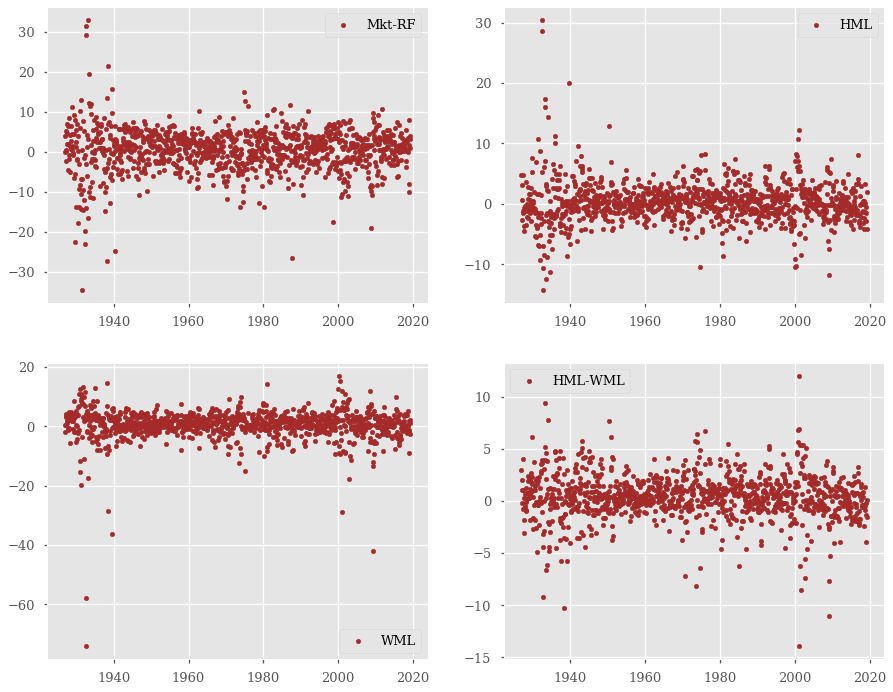

In [5]:
fig, ax = plt.subplots(2,2,figsize=(15,12))
ax = ax.ravel()
for i,c in enumerate(df_daily.columns):
    ax[i].scatter(df_monthly_log[c].index, df_monthly_log[c], label=c,color="brown",
                   s=20)
    ax[i].legend(loc="best")

In [6]:
# monthly simple returns (using the daily returns)
df_m  = ((1+df_daily/100).resample("1M").prod()-1)*100
# realized variance
df_rv = np.sqrt((df_daily**2).resample('1M').sum())*np.sqrt(12)

In [7]:
df_rv.tail()

Mkt-RF        HML        WML   HML-WML
Date                                                 
2018-12-31  29.145017  11.127372   7.897620  5.322222
2019-01-31  19.555828  10.727926  14.078068  7.014966
2019-02-28   8.268107   7.516542   6.908082  4.339987
2019-03-31  12.474614   7.951075   7.245357  4.673858
2019-04-30   7.225123   8.193461  10.834777  3.278439

### Data exploration

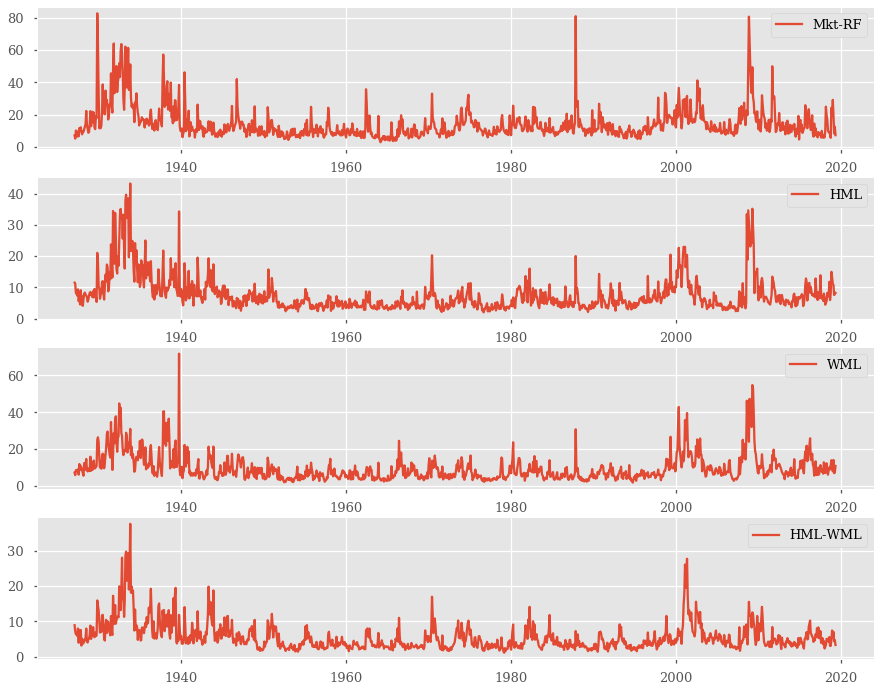

In [8]:
fig, ax = plt.subplots(df_rv.shape[1],1,figsize=(15,12))
ax = ax.ravel()
i = 0
for j in df_rv.columns:
    ax[i].plot(df_rv[j],label=j)
    ax[i].legend(loc="best", frameon=True, framealpha=1)
    i +=1

### Closer look at risk return

In [9]:
def compute_buckets(df=df_rv, lag=1, window=100 , buckets=5):

    start = 0
    end = window

    store_labels = {}
    df_rv_labels = df.shift(lag)[lag:]
    while end != len(df):
        # get previous window months
        x  = df_rv_labels.iloc[start:end]
        # caclulate which bucket it belongs based on the previous window months
        store_labels[df_rv_labels.index[end-1]] = (pd.qcut(x,buckets,labels=False).iloc[-1])
        end+=1
        start+=1
    return pd.DataFrame(store_labels, index=['Risk_bucket']).T

In [10]:
def risk_return(window=100, risk=None, returns=None):

    dic_risk = {}; dic_ret= {}
    for c in returns.columns:
        # dataframe with buckets, returns next month and risk next month
        df_rr = compute_buckets(df=risk[c], window=window)
        df_rr['returns'] = returns.iloc[window:][c]
        df_rr['risk'] = risk.iloc[window:][c]
        
        # loop over buckets and compute mean risk and return
        ret_list =[]; risk_list = []
        for i,j in df_rr.groupby(['Risk_bucket']):
            ret_list.append(np.mean(j["returns"]))  
            risk_list.append(np.mean(j["risk"]))
        dic_ret[c] = ret_list 
        dic_risk[c] = risk_list
    # put everything in a dataframe
    df_ret = pd.DataFrame(dic_ret)
    df_risk = pd.DataFrame(dic_risk)
    df_SR = df_ret.divide(df_risk)
    
    return(df_ret, df_risk, df_SR)

In [11]:
window = 100
risk = (df_daily).resample('1M').std()*np.sqrt(252)
returns = df_daily.resample("1M").mean()*252
df_ret, df_vol, df_SR = risk_return(window=100, risk=risk, returns=returns)

# normalize
df_ret_norm = df_ret/df_ret.sum()
df_vol_norm = df_vol/df_vol.sum()
df_SR_norm = df_SR/df_SR.sum()

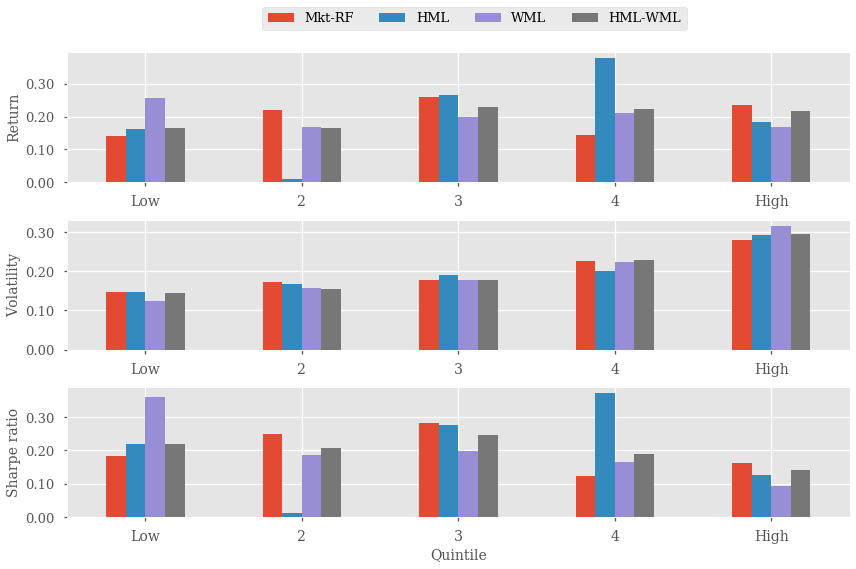

In [12]:
with plt.style.context('ggplot'):
    
    fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(12,8))
    ax = ax.ravel()

    df_ret_norm.plot.bar(rot=0, ax=ax[0], legend=False)
    df_vol_norm.plot.bar(rot=0, ax=ax[1],legend=False)
    df_SR_norm.plot.bar(rot=0, ax=ax[2], legend=False);
    ax[0].legend(bbox_to_anchor=(.80, 1.4), ncol=4);

    for i in range(3):
        ax[i].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))
        ax[i].set_xticklabels(["Low","2","3","4","High"],fontsize=14)

ax[0].set_ylabel("Return",fontsize=14)
ax[1].set_ylabel("Volatility",fontsize=14)
ax[2].set_ylabel("Sharpe ratio",fontsize=14)
ax[2].set_xlabel("Quintile",fontsize=14);
plt.tight_layout();
# plt.suptitle("Risk return trade-off",
#              y=1.05, fontsize=18, fontweight="bold", style="italic");

plt.savefig('Risk_Return.pdf', format='pdf', bbox_inches='tight') # save plot

In [13]:
def target_vol(target=None, returns=None, 
               risk=None, max_weight=10, error=0.001):
    
    # calculate target vol (c) with initial target 1
    c = target/(returns.divide(risk)).std()
    # update target
    w = (c/risk).clip_upper(max_weight)
    scaled = returns.multiply(w)
    # this should be zero or very close to zero
    diff = scaled.std()-target                
    return c

In [14]:
def scaled_portfolio(returns=None, risk=None, freq=FREQUENCY, max_weight=10, target_level_vol=None):

    weight_dic = {}
    scaled_dic = {}

    for c in returns.columns:
        # target vol
        target = returns[c].std() if target_level_vol is None else target_level_vol 
        # make target vol equal to original factor
        out = target_vol(target=target, returns=returns[c], 
                   risk=risk[c])

        # scaled portfolio
        weight = (out/risk[c]).clip_upper(max_weight)
        scaled_ret_d = returns[c].multiply(weight)
        weight_dic[c] = weight
        scaled_dic[c] = scaled_ret_d
    return(pd.DataFrame(weight_dic), pd.DataFrame(scaled_dic))

### Important !!
 Before 1952 there was also trading on saterday
 therefore 126 days is actually 5 month before that date and 6 month after that date 
  - https://www.marketwatch.com/story/a-brief-history-of-trading-hours-on-wall-street-2015-05-29

In [15]:

window = 6
RV = np.sqrt(df_daily**2).resample("1M").sum()
# no shift 1 to use the vol of that month (sort of check for max potential)
RV_max  = ((RV.rolling(window=1).sum()/21))[window+1:] # 21 days in a month
# the shift is to move 1 up (avoid look ahead bias)
RV_6 = ((RV.rolling(window=6).sum()/126)).shift(1)[window+1:] # 126 days in 6 months
Returns_monthly = (((1+df_daily/100).resample("1M").prod()-1)*100)[window+1:] 

In [16]:
# rough estimation of the maximum potential by using the next month realized volatility from daily returns
out_w_max, out_r_max = scaled_portfolio(returns=Returns_monthly, risk=RV_max)

# using the past 6 month vol (from daily returns) to estimate future vol
out_w_6, out_r_6 = scaled_portfolio(returns=Returns_monthly, risk=RV_6)

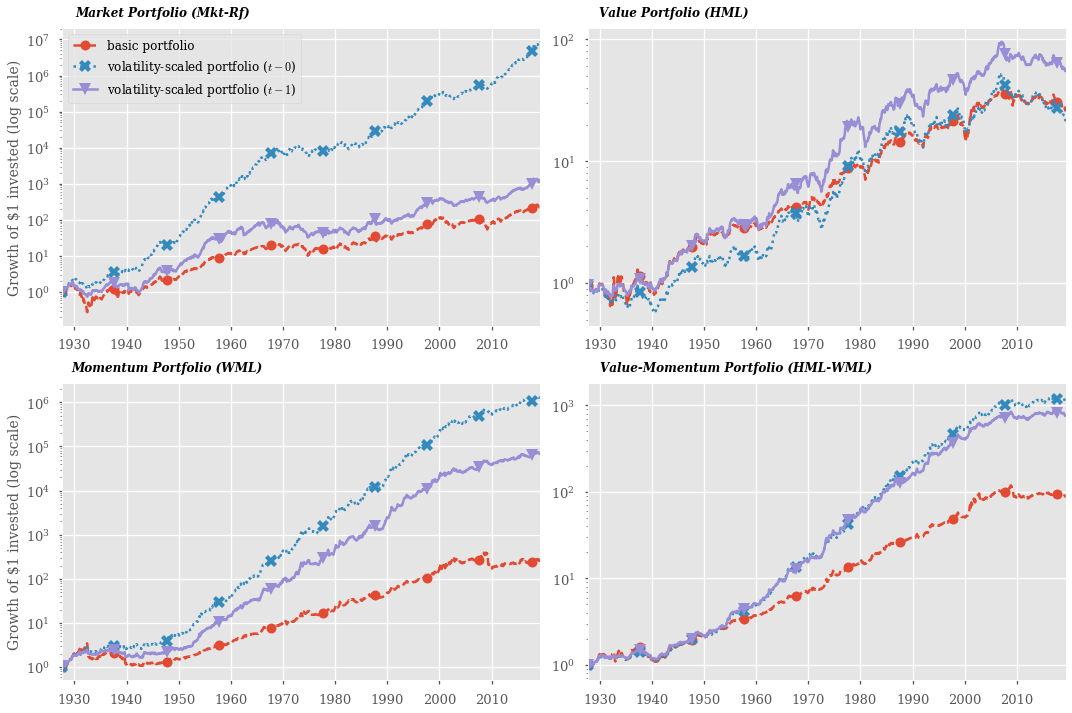

In [17]:

markevery=FREQUENCY * 5,
markersize=8
#markers=["o", "v", "*", "X"]

portfolios_names = {"Mkt-RF":"Market Portfolio (Mkt-Rf)",
                   "HML":"Value Portfolio (HML)",
                   "WML":"Momentum Portfolio (WML)",
                   "HML-WML":"Value-Momentum Portfolio (HML-WML)"}

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
ax = ax.ravel()
for i, c in enumerate(Returns_monthly.columns):
    orig = (1+Returns_monthly[c]/100).cumprod()
    vm_t0 = (1+out_r_max[c]/100).cumprod()
    vm_t1 = (1+out_r_6[c]/100).cumprod()
    ax[i].plot(orig,label='basic portfolio',lw=2.5,
               linestyle="--",marker="o",markersize=10, markevery=FREQUENCY * 10)
    ax[i].plot(vm_t0, label= r'volatility-scaled portfolio ($t-0$)',
               lw=2.5,linestyle="dotted", marker="X",markersize=12, markevery=FREQUENCY * 10)
    ax[i].plot(vm_t1, label= r"volatility-scaled portfolio ($t-1$)",
               lw=2.5, marker="v",markersize=12, markevery=FREQUENCY * 10)
    ax[i].set_yscale('log')
    ax[i].set_xlim([vm_t1.index[0], vm_t1.index[-1]])
#plt.tight_layout()
ax[0].set_ylabel("Growth of $1 invested (log scale)", fontsize=14)
ax[2].set_ylabel("Growth of $1 invested (log scale)", fontsize=14)
ax[0].legend(loc="best",fontsize = 'large');
ax[0].set_title(portfolios_names.get("Mkt-RF"),style="italic",fontweight="bold",x=.21,y=1.02,fontsize=12)
ax[1].set_title(portfolios_names.get("HML"),style="italic",fontweight="bold",x=.18,y=1.02,fontsize=12)
ax[2].set_title(portfolios_names.get("WML"),style="italic",fontweight="bold",x=.22,y=1.02,fontsize=12)
ax[3].set_title(portfolios_names.get("HML-WML"),style="italic",fontweight="bold",x=.31,y=1.02,fontsize=12);
plt.tight_layout()
plt.savefig('vol_portfolio.pdf', format='pdf')

## Define performance stats

In [18]:
"""
some anonymous function to calculate various (performance) statistics,
these functions are stored in a dictionary

params:

    - df: pandas dataframe with the raw returns
    - time_freq: an integer indicating the number of trading days
    - treshold: a float determining the level of drawdown is taken into account
      when calculating the percentage of time an investment is in a drawdown state


returns:

    - numpy array with the calculted statistic
"""


def P_Gr(time_freq=FREQUENCY, df=None):    return \
(np.exp(time_freq*np.mean(df.values/100, axis=0))-1)*100


def P_Gvol(time_freq=FREQUENCY, df=None):    return \
(np.exp(np.sqrt(time_freq)*np.std(df.values/100, axis=0))-1)*100


# put functions into a dictionary, so we can choose which one to call
PERF_STAT_DIC = {
    
    "N":
    lambda df=None:df.describe().loc["count",:].values,   
    "Min":
    lambda df=None:df.min().values,
    "25 %":
    lambda df=None:np.percentile(df,25,axis=0),
    "50 %":
    lambda df=None:np.percentile(df,50,axis=0),
    "75 %":
    lambda df=None:np.percentile(df,75,axis=0),
    "Max":
    lambda df=None:df.max().values,
    "Mean":
    lambda df=None: np.mean(df.values, axis=0),
    "SD":
    lambda df=None: df.std().values,
    "Skew":
    lambda df=None: df.skew().values,
    "Kurtosis":
    lambda df=None: df.kurtosis().values,
    "Terminal Wealth":
    lambda df=None: (1+df / 100).cumprod().iloc[-1, :],
    "Mean (yr)":
    lambda time_freq=FREQUENCY, df=None: df.mean()*time_freq,
    "SD (yr)":
    lambda time_freq=FREQUENCY, df=None: df.std()*np.sqrt(time_freq),
    "SR (yr)":
    lambda time_freq=FREQUENCY, df=None: (df.mean().values/df.std().values)*np.sqrt(time_freq),
    "SR":
    lambda time_freq=FREQUENCY, df=None: df.mean().values/df.std().values,
    "Kappa Ratio":
    lambda threshold_risk=0, threshold_return=0, order=3, time_freq=FREQUENCY,
    df=None: kappa_ratio(threshold_risk=threshold_risk,
                         threshold_return=threshold_return,
                         order=order,
                         time_freq=1,
                         df=df),
    "MDD (%)":
    lambda df=None: np.max(drawdown(df=df), axis=0) * 100,
    "Calmar Ratio (yr)":
    lambda time_freq=FREQUENCY, df=None: df.mean()*time_freq / (
        np.max(drawdown(df=df), axis=0) * 100),
    "Max TUW (Year)":
    lambda time_freq=FREQUENCY, df=None: np.max(np.apply_along_axis(
        max_time_dd, 0, drawdown(df=df)),
                                                axis=0) / time_freq,
    "Underwater (%)":
    lambda df=None: np.sum(drawdown(df=df) != 0, axis=0) / len(df) * 100,
    f"% MDD >{20} %":
    lambda treshold=0.20, df=None: np.sum(drawdown(df=df) > treshold, axis=0
                                          ) / len(df) * 100
}

In [19]:
def sharpe_ratio(x, freq=FREQ_SR):
    
    mu, sigma = freq * x.mean(), np.sqrt(freq * x.var())
    values = np.array([mu, sigma, mu / sigma ]).squeeze()
    index = ['mu', 'sigma', 'SR']
    return pd.Series(values, index=index)

In [20]:
def diff_sharpe_ratio(x=None,y=None, freq=FREQ_SR):
    
    return sharpe_ratio(x, freq=freq)-sharpe_ratio(y, freq=freq)


## Construct volatility managed portfolios
 -  daily data using past 126 days
 -  monthly data using RV over past 126 days
 -  note that there were 25 trading days in a month till 1952

### Daily

In [21]:
window_daily = 126 # same window as Barosso-Santa-Clara and Moskowitz and Kent
# the shift 1 is to avoid look ahead bias and add to the same level as the return data
shift = 2 # extra shift to be sure
RV_daily = np.sqrt((df_daily**2).rolling(window=window_daily).sum()/window_daily).shift(shift)
# remove NA
risk_daily = RV_daily[window_daily+shift:]
returns_daily = df_daily[window_daily+shift:]

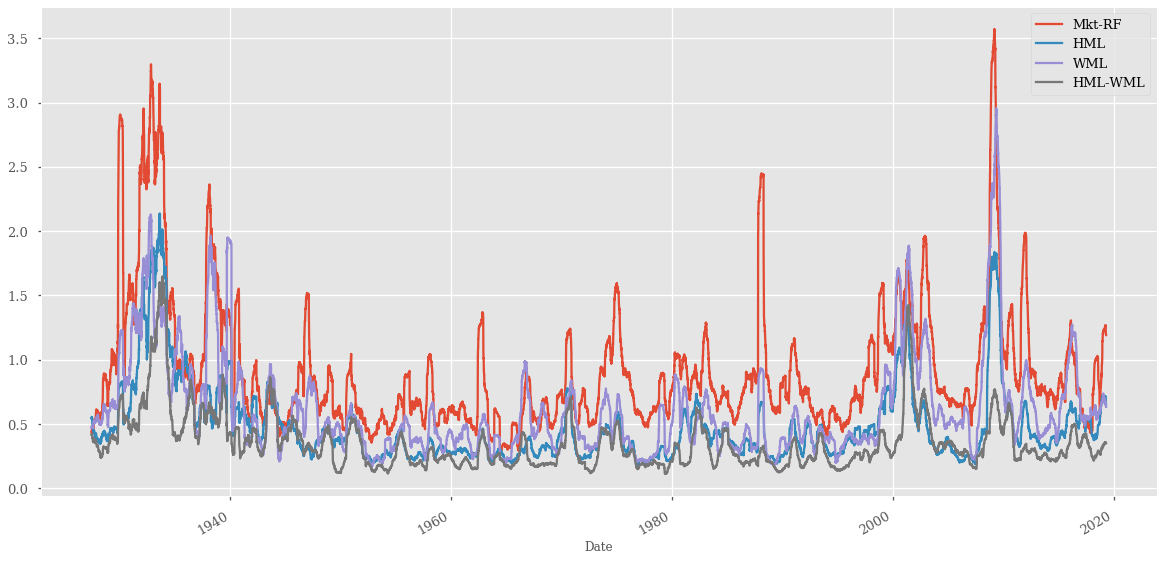

In [22]:
 risk_daily.plot(figsize=(20,10));

### Monthly

In [23]:
window_month = 6
# the shift 1 is to avoid look ahead bias and add to the same level as the return data
shift = 1
RV_m = np.sqrt(df_daily**2).resample("1M").sum()
RV_m = ((RV_m.rolling(window=window_month).sum()/126)).shift(shift)
df_m = (((1+df_daily/100).resample("1M").prod()-1)*100)
# remove NA
risk_monthly = RV_m[window_month+shift:]
returns_monthly = df_m[window_month+shift:]

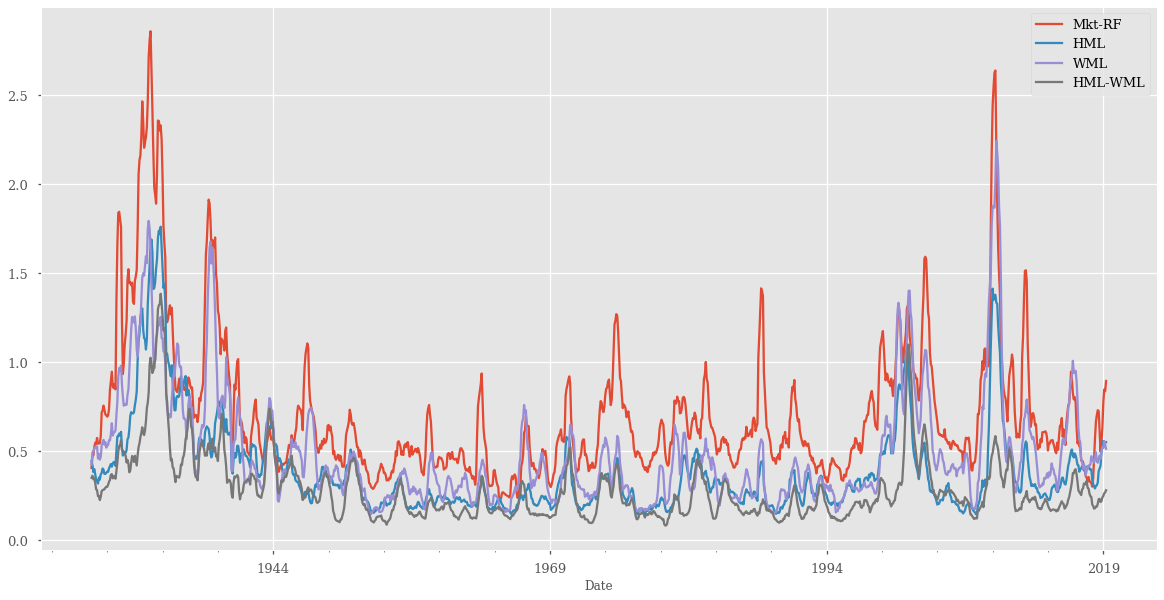

In [24]:
risk_monthly.plot(figsize=(20,10));

## Helper functions

In [25]:
def compare_perf(constant=None, vol_man=None,
                 sub_columns=["Constant", "Vol. managed"],
                 names=["Portfolio", "Position size"]):
    
    create_df = True
    for c in constant.columns:
    
        if create_df:
            x = pd.DataFrame(constant[c].values,columns=[f"constant {c}"],index=constant.index)
            create_df=False
        else:
            x[f"constant {c}"] = constant[c]

        x[f"vol_m {c}"] = vol_man[c]

        cols = pd.MultiIndex.from_product([constant.columns,
                                        sub_columns],
                                       names=names)

    compare_performance = round(pd.DataFrame(x.values, index=x.index, columns=cols),4)
    return compare_performance

In [26]:
def CI_diff(df_1, df_2, boots=100, blocksize=BLOCKSIZE):
    
    pe = diff_sharpe_ratio(x=df_1, y=df_2)
    bs = CircularBlockBootstrap(blocksize, df_1, df_2)
    ci = bs.conf_int(diff_sharpe_ratio, boots, method="norm")  # studentized: very slow 
    a = pd.DataFrame(ci,columns=['mu','sigma','SR'],index=["Lower","Upper"])
    return pd.concat([pd.DataFrame(pe,columns=["Diff"]).T,a])   

In [27]:
def plot_compare_return(df1=None, df2=None, figsize=(14,10),labels=["UM","VM"]):
    fig, ax = plt.subplots(nrows=2, ncols=2,figsize=figsize)
    ax = ax.ravel()
    for i, c in enumerate(df1.columns):
        a = (1+df1[c]/100).cumprod()
        b = (1+df2[c]/100).cumprod()
        ax[i].plot(a, label=f'{c} {labels[0]}')
        ax[i].plot(b, label=f'{c} {labels[1]}')
        ax[i].set_yscale('log')
        ax[i].set_xlim([df1.index[0], df1.index[-1]])
        ax[i].legend(loc="best")
    ax[0].set_ylabel(r"Growth of $1 invested (log scale)",fontsize=14)
    ax[2].set_ylabel(r"Growth of $1 invested (log scale)",fontsize=14)
    plt.tight_layout()

In [28]:
def plot_weights(weights=None, figsize=(14,10)):
    fig, ax = plt.subplots(nrows=2, ncols=2,figsize=figsize)
    ax = ax.ravel()
    for i, c in enumerate(weights.columns):
        ax[i].plot(weights[c], label=c,linestyle="--")
        ax[i].set_xlim([weights.index[0], weights.index[-1]])
        ax[i].legend(loc="best")
    ax[0].set_ylabel(r"leverage ($w_t$)",fontsize=14)
    ax[2].set_ylabel(r"leverage ($w_t$)",fontsize=14)
    plt.tight_layout()

In [29]:
def compare_perf_num(df1, df2=None, stats=None, 
                     stat_CI="SR",boots=1000,
                     sub_columns = ["Constant", "Vol. managed"],
                     names=["Portfolio", "Position size"]):
    
    # get CI
    store  =[CI_diff(df_1 = df1[c], df_2 = df2[c], boots=boots)[stat_CI].values for c in df1.columns]
    out = pd.DataFrame(store, index=df1.columns,
                       columns=[f'Diff {stat_CI}',f'Lower CI {stat_CI}',f'Upper CI {stat_CI}']).T

    # constant (unmanaged strategy)
    constant = perf_stat(df=df2, all_stats=True, dic_perf=PERF_STAT_DIC)
    constant = pd.concat([constant, out])
    
    # volatility managed (VM) strategy
    vol_man = perf_stat(df=df1, all_stats=True, dic_perf=PERF_STAT_DIC)
    vol_man = pd.concat([vol_man, out])
    
    out =  compare_perf(constant=constant, vol_man=vol_man, 
                        sub_columns=sub_columns, names=names)
    if stats is None:
        return out
    else:
        return out.loc[stats,:]

In [30]:
def write_to_csv(df_vm=None,df_orig=None, name=None,directory=PATH_DATA_1):
    vm = pd.DataFrame(df_vm.values, 
                 index=df_vm.index, columns=["VM_Mkt","VM_HML","VM_WML","VM_HMLWML"])
    out = pd.concat([df_orig,vm], axis=1, join='inner')
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    out.to_csv(directory+f"{name}.csv",index=True)
    print("Complete")

## Global parameters

In [31]:
# main dictionary
STORE_MAIN= {}
# subdictionary unlimited leverage
STORE_SUB_UL = {}
# subdictionary limited leverage
STORE_SUB_LL = {}

RETURNS = returns_monthly
VOL = risk_monthly
TEST_STAT = "SR"

METRICS_THESIS = ["N","Min","50 %","Max","Mean","SD","Skew","Kurtosis","Mean (yr)",
         "SD (yr)","MDD (%)","% MDD >20 %","SR (yr)","SR",
         "Diff SR","Lower CI SR","Upper CI SR"] # stats to include for thesis

# decimal points
pd.options.display.float_format = '{:.3f}'.format

## unlimited leverage

 ###  Full sample

Complete


Portfolio           Mkt-RF                   HML                   WML  \
Position size     Constant Vol. managed Constant Vol. managed Constant   
N                 1101.000     1101.000 1101.000     1101.000 1101.000   
Min                -29.122      -34.736  -13.035      -10.251  -29.816   
25 %                -1.997       -2.429   -1.282       -1.555   -1.114   
50 %                 1.019        1.235    0.141        0.186    0.668   
75 %                 3.587        4.173    1.741        2.188    2.766   
Max                 38.894       18.059   27.581       16.459   22.590   
Mean                 0.651        0.798    0.352        0.420    0.604   
SD                   5.349        5.349    3.321        3.321    4.391   
Skew                 0.201       -0.669    1.279        0.456   -0.927   
Kurtosis             7.960        2.529    9.527        1.246    8.524   
Terminal Wealth    264.982     1276.455   26.644       55.732  254.933   
Mean (yr)            7.812        9.577    4.227        5.043    7.248   
SD (yr)             18.531       18.531   11.503       11.503   15.210   
SR (yr)              0.422        0.517    0.367        0.438    0.476   
SR                   0.122        0.149    0.106        0.127    0.138   
Kappa Ratio          0.120        0.146    0.124        0.156    0.117   
MDD (%)             84.631       67.401   43.358       42.761   69.199   
Calmar Ratio (yr)    0.092        0.142    0.098        0.118    0.105   
Max TUW (Year)      15.417       18.500   12.333       12.333   25.500   
Underwater (%)      78.928       81.290   81.925       83.106   83.560   
% MDD >20 %         35.695       42.053   13.624       21.798   39.600   
Diff SR              0.028        0.028    0.021        0.021    0.116   
Lower CI SR         -0.006       -0.006   -0.015       -0.015    0.076   
Upper CI SR          0.061        0.061    0.056        0.056    0.155   

Portfolio                       HML-WML               
Position size     Vol. managed Constant Vol. managed  
N                     1101.000 1101.000     1101.000  
Min                    -19.151  -11.870       -8.053  
25 %                    -1.313   -0.561       -0.696  
50 %                     0.827    0.380        0.470  
75 %                     3.598    1.516        1.907  
Max                     20.073   15.294       10.350  
Mean                     1.112    0.433        0.629  
SD                       4.391    2.237        2.237  
Skew                    -0.023   -0.128        0.369  
Kurtosis                 1.761    4.827        1.537  
Terminal Wealth      68063.356   89.018      761.614  
Mean (yr)               13.339    5.202        7.551  
SD (yr)                 15.210    7.748        7.748  
SR (yr)                  0.877    0.671        0.975  
SR                       0.253    0.194        0.281  
Kappa Ratio              0.291    0.195        0.365  
MDD (%)                 36.009   38.356       25.805  
Calmar Ratio (yr)        0.370    0.136        0.293  
Max TUW (Year)          11.167   10.500        8.000  
Underwater (%)          74.114   73.388       70.572  
% MDD >20 %              8.901   14.441        1.726  
Diff SR                  0.116    0.087        0.087  
Lower CI SR              0.076    0.056        0.056  
Upper CI SR              0.155    0.119        0.119

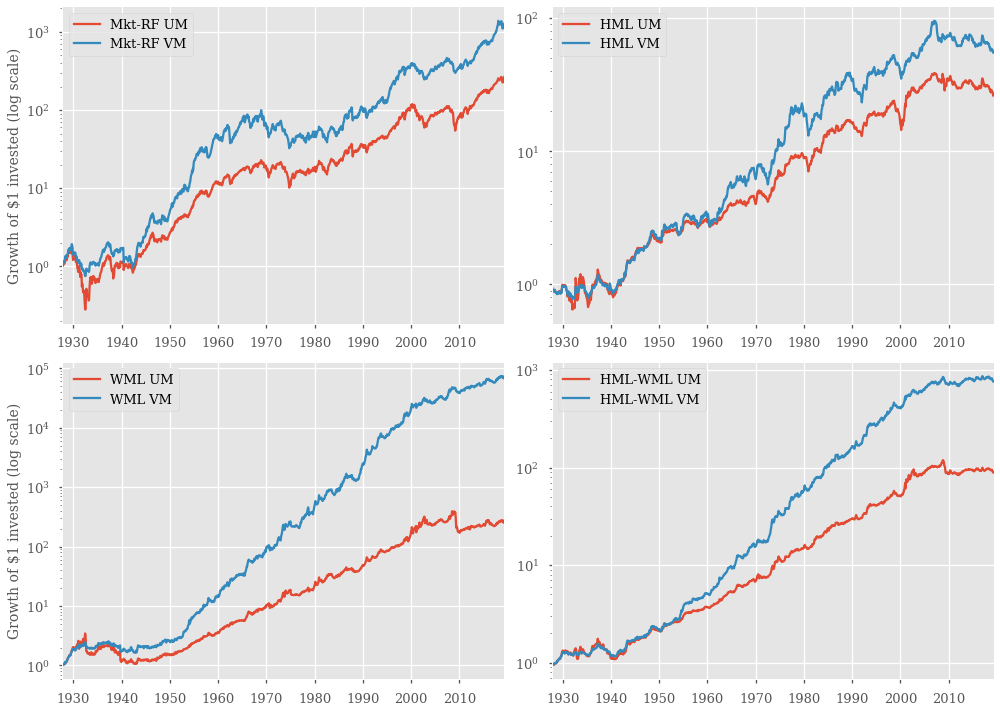

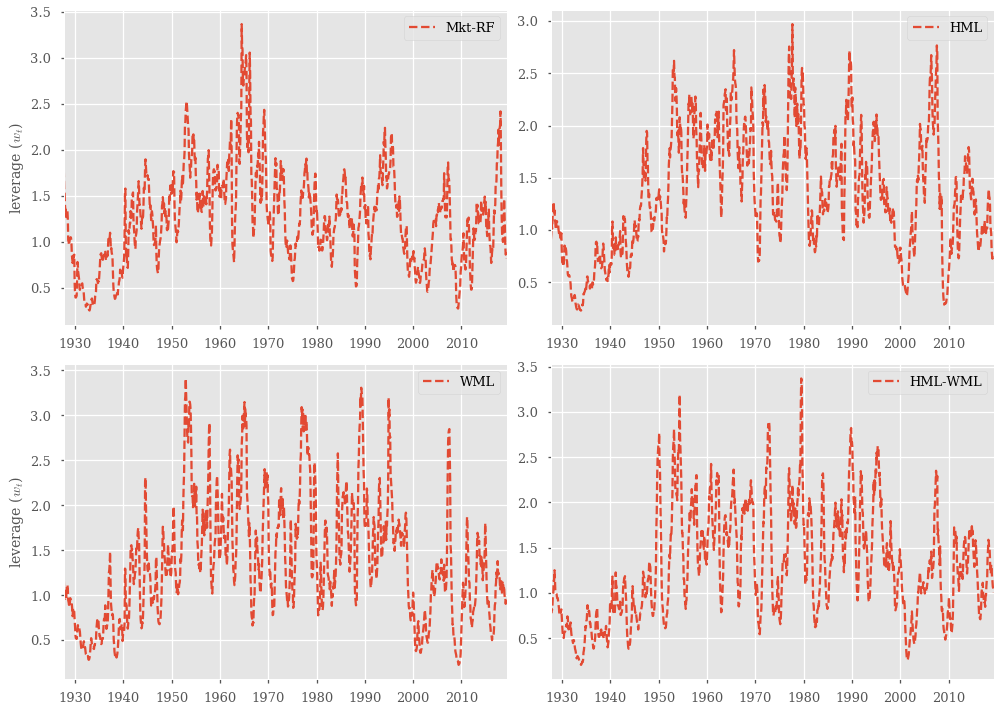

In [32]:
df_weights_ul, df_scaled_ul = scaled_portfolio(returns=RETURNS, risk=VOL, max_weight=10)

plot_compare_return(df1=RETURNS, df2=df_scaled_ul)
plot_weights(weights=df_weights_ul)
plt.savefig('full_sample_weight.pdf', format='pdf')
    
    
# write to csv
write_to_csv(df_vm=df_scaled_ul,df_orig=RETURNS,name="ul_1927-2019")

#store perormance
cp_ulfs = compare_perf_num(df1=df_scaled_ul, df2=RETURNS, stat_CI=TEST_STAT)
STORE_SUB_UL["full_sample"] = cp_ulfs

cp_ulfs
#print(cp_ulfs.loc[METRICS_THESIS,:].to_latex())

In [33]:
# cc = pd.DataFrame(drawdown(RETURNS)>0.2,columns=RETURNS.columns+"_DD",index=RETURNS.index)
# cc = pd.concat([RETURNS,cc],axis=1)
# bb =pd.DataFrame(df_scaled_ul.values, index=df_scaled_ul.index, columns=df_scaled_ul.columns+"VM")
# cc = pd.concat([cc, bb],axis=1)

# regress_test=("C:\\Users\\Pieter-Jan\\Documents\\Factor_Crashes\\Code\\Simulation\\"
# "VM_portfolios\\other\\regression.csv")

# cc.to_csv(regress_test,index=True)

###  Subperiods
 
 - 1927-1949
 - 1950-1974
 - 1975-1999
 - 2000-2019
 
#### 1927-1949

Complete


Portfolio           Mkt-RF                   HML                   WML  \
Position size     Constant Vol. managed Constant Vol. managed Constant   
N                  269.000      269.000  269.000      269.000  269.000   
Min                -29.122      -48.470  -13.035      -10.177  -29.816   
25 %                -2.915       -3.610   -1.755       -2.030   -1.906   
50 %                 1.019        1.191    0.030        0.028    0.350   
75 %                 4.823        5.730    2.251        2.920    3.075   
Max                 38.894       20.003   27.581       22.167   22.590   
Mean                 0.677        1.088    0.391        0.579    0.328   
SD                   7.874        7.874    4.802        4.802    5.729   
Skew                 0.521       -1.019    1.483        0.917   -1.020   
Kurtosis             5.418        5.343    7.085        1.964    7.051   
Terminal Wealth      2.711        7.573    2.126        3.504    1.521   
Mean (yr)            8.120       13.054    4.691        6.944    3.939   
SD (yr)             27.277       27.277   16.636       16.636   19.845   
SR (yr)              0.298        0.479    0.282        0.417    0.199   
SR                   0.086        0.138    0.081        0.120    0.057   
Kappa Ratio          0.090        0.124    0.102        0.166    0.048   
MDD (%)             84.631       74.027   43.358       43.255   69.199   
Calmar Ratio (yr)    0.096        0.176    0.108        0.161    0.057   
Max TUW (Year)      15.417        7.417    5.833        6.833   17.583   
Underwater (%)      88.848       86.617   86.617       84.758   89.591   
% MDD >20 %         67.658       67.658   28.625       29.368   78.439   
Diff SR              0.052        0.052    0.039        0.039    0.058   
Lower CI SR         -0.018       -0.018   -0.014       -0.014    0.006   
Upper CI SR          0.122        0.122    0.092        0.092    0.110   

Portfolio                       HML-WML               
Position size     Vol. managed Constant Vol. managed  
N                      269.000  269.000      269.000  
Min                    -30.284  -10.461       -7.175  
25 %                    -2.700   -1.041       -1.132  
50 %                     0.539    0.293        0.353  
75 %                     3.882    1.949        2.010  
Max                     14.407    8.237       10.532  
Mean                     0.659    0.319        0.484  
SD                       5.729    2.720        2.720  
Skew                    -0.540   -0.370        0.338  
Kurtosis                 2.865    1.857        1.097  
Terminal Wealth          3.737    2.132        3.322  
Mean (yr)                7.904    3.826        5.806  
SD (yr)                 19.845    9.423        9.423  
SR (yr)                  0.398    0.406        0.616  
SR                       0.115    0.117        0.178  
Kappa Ratio              0.111    0.118        0.220  
MDD (%)                 53.445   38.356       37.698  
Calmar Ratio (yr)        0.148    0.100        0.154  
Max TUW (Year)          11.667    7.833        6.000  
Underwater (%)          88.848   82.528       79.926  
% MDD >20 %             55.762   22.677       17.844  
Diff SR                  0.058    0.061        0.061  
Lower CI SR              0.006    0.005        0.005  
Upper CI SR              0.110    0.116        0.116

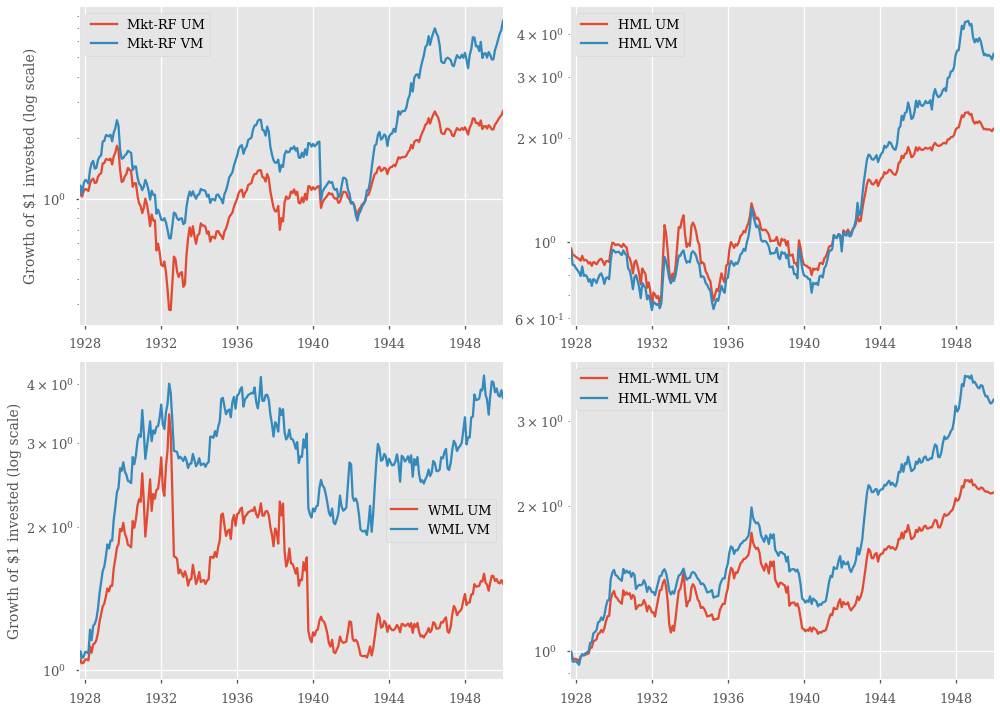

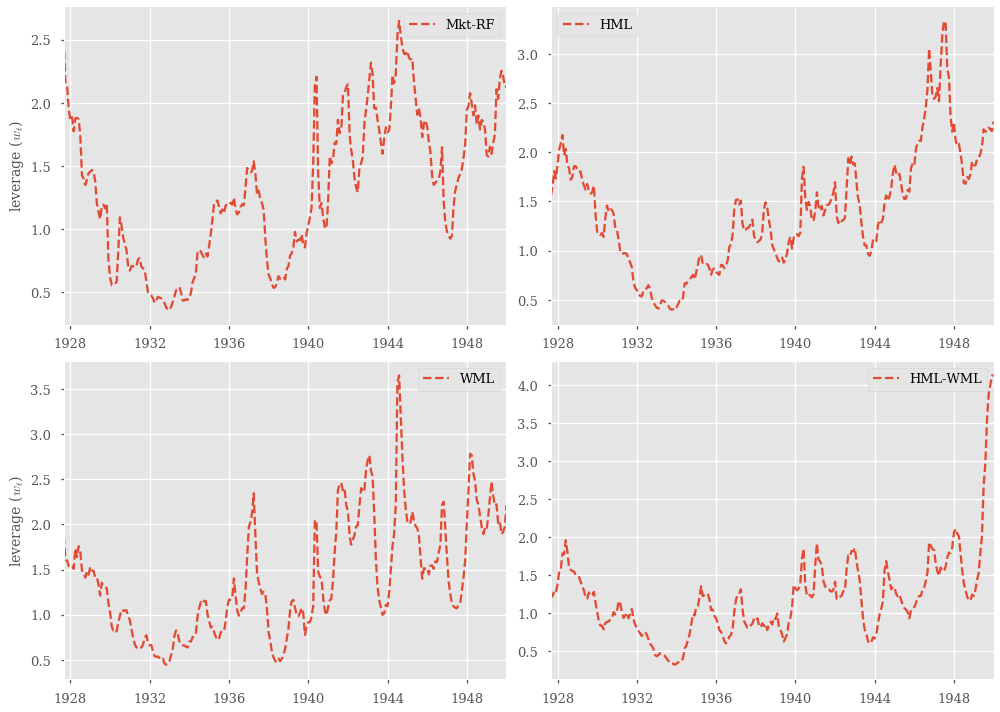

In [34]:
ys,ms,ds = 1927,6,3
ye,me,de = 1949,12,31

# subset returns and risk (predicted vol)
returns_49 = RETURNS.loc[datetime.date(year=ys,month=ms,day=ds):
                                     datetime.date(year=ye,month=me,day=de)]

risk_49 = VOL.loc[datetime.date(year=ys,month=ms,day=ds):
                                  datetime.date(year=ye,month=me,day=de)]

# get scaled portfolio
df_weights_ul_49, df_scaled_ul_49 = scaled_portfolio(returns=returns_49, 
                                                         risk=risk_49, max_weight=10)
# write to csv
write_to_csv(df_vm=df_scaled_ul_49,df_orig=returns_49,name="ul_1927-1949")

# compare performance
plot_compare_return(df1=returns_49, df2=df_scaled_ul_49)
plot_weights(weights=df_weights_ul_49)
cp_ul49 = compare_perf_num(df1=df_scaled_ul_49, df2=returns_49, stat_CI=TEST_STAT)

#store perormance
STORE_SUB_UL["49"] = cp_ul49
cp_ul49

#### 1950-1974

Complete


Portfolio           Mkt-RF                   HML                   WML  \
Position size     Constant Vol. managed Constant Vol. managed Constant   
N                  300.000      300.000  300.000      300.000  300.000   
Min                -12.720      -11.477   -8.664       -6.562  -11.123   
25 %                -1.904       -1.940   -0.853       -0.882   -0.723   
50 %                 0.759        0.856    0.275        0.284    1.030   
75 %                 3.111        3.410    1.557        1.728    2.584   
Max                 16.081       11.939   13.812       10.536   10.826   
Mean                 0.542        0.536    0.402        0.382    0.885   
SD                   3.925        3.925    2.301        2.301    3.000   
Skew                -0.286       -0.446    0.721        0.400   -0.232   
Kurtosis             0.916        0.172    4.299        1.201    1.787   
Terminal Wealth      4.021        3.948    3.079        2.902   12.303   
Mean (yr)            6.504        6.434    4.819        4.583   10.618   
SD (yr)             13.595       13.595    7.972        7.972   10.392   
SR (yr)              0.478        0.473    0.605        0.575    1.022   
SR                   0.138        0.137    0.174        0.166    0.295   
Kappa Ratio          0.148        0.146    0.214        0.208    0.331   
MDD (%)             55.528       50.797   17.937       20.014   16.988   
Calmar Ratio (yr)    0.117        0.127    0.269        0.229    0.625   
Max TUW (Year)       6.083        6.083    3.833        3.750    1.750   
Underwater (%)      68.667       74.333   77.333       77.000   59.333   
% MDD >20 %         12.000       25.333    0.000        0.333    0.000   
Diff SR             -0.002       -0.002   -0.009       -0.009    0.060   
Lower CI SR         -0.045       -0.045   -0.041       -0.041    0.027   
Upper CI SR          0.043        0.043    0.023        0.023    0.093   

Portfolio                       HML-WML               
Position size     Vol. managed Constant Vol. managed  
N                      300.000  300.000      300.000  
Min                     -9.335   -7.354       -5.107  
25 %                    -0.816   -0.318       -0.356  
50 %                     1.169    0.379        0.460  
75 %                     2.692    1.494        1.731  
Max                     10.019    7.245        7.783  
Mean                     1.065    0.584        0.711  
SD                       3.000    1.773        1.773  
Skew                    -0.040    0.139        0.503  
Kurtosis                 0.860    3.601        1.217  
Terminal Wealth         21.047    5.478        8.006  
Mean (yr)               12.783    7.009        8.535  
SD (yr)                 10.392    6.143        6.143  
SR (yr)                  1.230    1.141        1.389  
SR                       0.355    0.329        0.401  
Kappa Ratio              0.449    0.374        0.604  
MDD (%)                 12.137    9.034        5.910  
Calmar Ratio (yr)        1.053    0.776        1.444  
Max TUW (Year)           1.333    2.500        2.083  
Underwater (%)          57.000   60.000       57.000  
% MDD >20 %              0.000    0.000        0.000  
Diff SR                  0.060    0.072        0.072  
Lower CI SR              0.027    0.027        0.027  
Upper CI SR              0.093    0.116        0.116

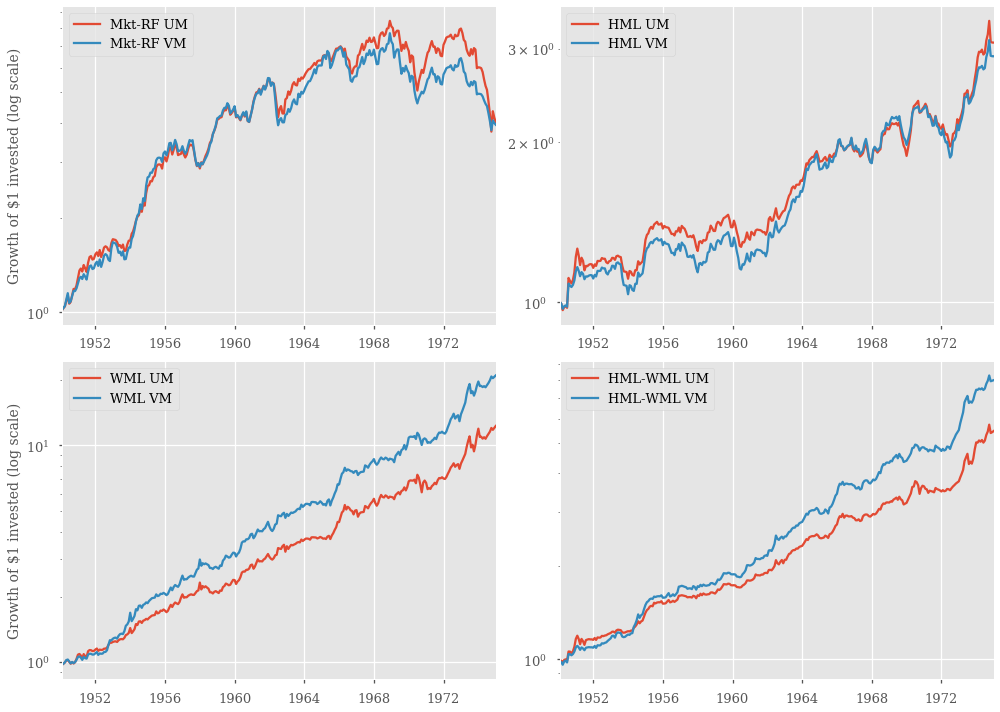

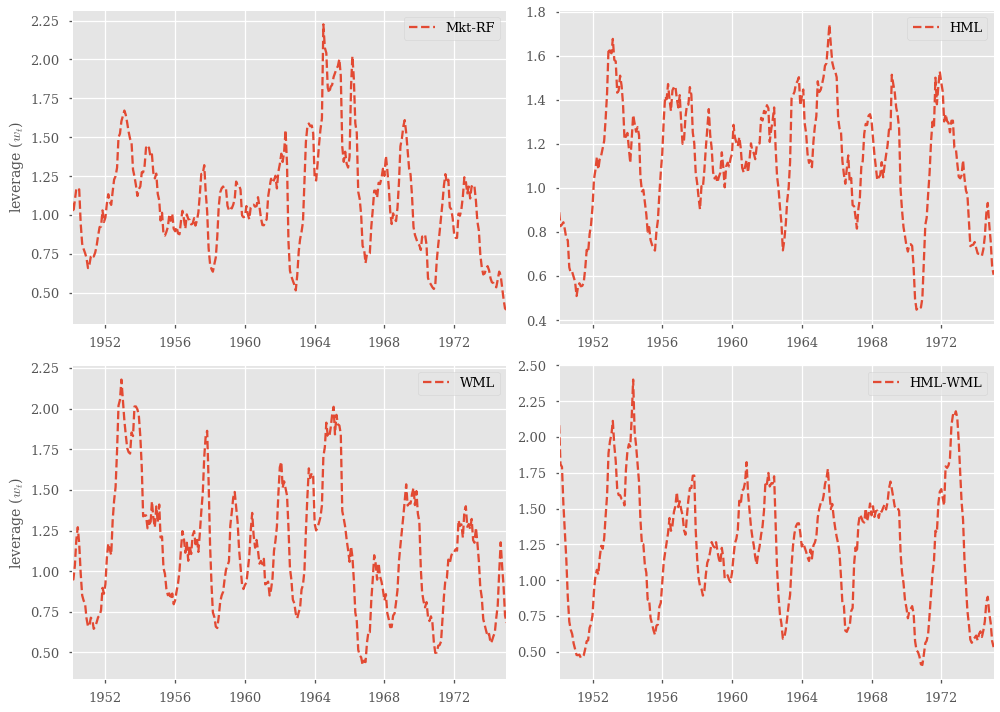

In [35]:
ys,ms,ds = 1950,1,1
ye,me,de = 1974,12,31

# subset returns and risk (predicted vol)
returns_74 = RETURNS.loc[datetime.date(year=ys,month=ms,day=ds):
                                     datetime.date(year=ye,month=me,day=de)]

risk_74 = VOL.loc[datetime.date(year=ys,month=ms,day=ds):
                                  datetime.date(year=ye,month=me,day=de)]

# get scaled portfolio
df_weights_ul_74, df_scaled_ul_74 = scaled_portfolio(returns=returns_74, 
                                                         risk=risk_74, max_weight=10)

# write to csv
write_to_csv(df_vm=df_scaled_ul_74,df_orig=returns_74,name="ul_1950-1974")

# compare performance
plot_compare_return(df1=returns_74, df2=df_scaled_ul_74)
plot_weights(weights=df_weights_ul_74)
cp_ul74 = compare_perf_num(df1=df_scaled_ul_74, df2=returns_74, stat_CI=TEST_STAT)

#store perormance
STORE_SUB_UL["74"] = cp_ul74

cp_ul74

#### 1975-1999

Complete


Portfolio           Mkt-RF                   HML                   WML  \
Position size     Constant Vol. managed Constant Vol. managed Constant   
N                  300.000      300.000  300.000      300.000  300.000   
Min                -23.123      -20.913   -7.654       -7.056  -14.670   
25 %                -1.766       -1.867   -1.280       -1.317   -0.723   
50 %                 1.074        1.164    0.340        0.361    0.882   
75 %                 3.823        3.397    1.672        1.712    2.679   
Max                 13.307       12.384    7.844        9.704   15.658   
Mean                 0.891        0.784    0.331        0.333    0.809   
SD                   4.421        4.421    2.608        2.608    3.343   
Skew                -0.711       -0.678    0.208        0.290   -0.296   
Kurtosis             3.284        2.390    0.502        0.618    3.366   
Terminal Wealth     10.671        7.744    2.433        2.448    9.504   
Mean (yr)           10.697        9.404    3.966        3.990    9.710   
SD (yr)             15.315       15.315    9.034        9.034   11.581   
SR (yr)              0.699        0.614    0.439        0.442    0.839   
SR                   0.202        0.177    0.127        0.128    0.242   
Kappa Ratio          0.197        0.174    0.151        0.155    0.251   
MDD (%)             33.072       30.947   33.648       31.667   17.403   
Calmar Ratio (yr)    0.324        0.304    0.118        0.126    0.558   
Max TUW (Year)       3.667        2.500    3.833        4.417    3.083   
Underwater (%)      71.667       74.333   77.333       82.000   73.333   
% MDD >20 %          6.667        7.667    3.667        9.333    0.000   
Diff SR             -0.024       -0.024    0.001        0.001    0.074   
Lower CI SR         -0.057       -0.057   -0.043       -0.043    0.036   
Upper CI SR          0.008        0.008    0.044        0.044    0.112   

Portfolio                       HML-WML               
Position size     Vol. managed Constant Vol. managed  
N                      300.000  300.000      300.000  
Min                    -12.369   -5.520       -5.477  
25 %                    -0.760   -0.376       -0.451  
50 %                     0.970    0.594        0.613  
75 %                     2.946    1.382        1.449  
Max                     13.187    6.258        6.766  
Mean                     1.056    0.507        0.585  
SD                       3.343    1.774        1.774  
Skew                    -0.117   -0.067        0.107  
Kurtosis                 1.409    1.069        1.214  
Terminal Wealth         19.853    4.350        5.498  
Mean (yr)               12.678    6.083        7.024  
SD (yr)                 11.581    6.146        6.146  
SR (yr)                  1.095    0.990        1.143  
SR                       0.316    0.286        0.330  
Kappa Ratio              0.374    0.340        0.417  
MDD (%)                 17.612   12.026        8.707  
Calmar Ratio (yr)        0.720    0.506        0.807  
Max TUW (Year)           2.750    1.833        1.583  
Underwater (%)          69.333   65.000       64.000  
% MDD >20 %              0.000    0.000        0.000  
Diff SR                  0.074    0.044        0.044  
Lower CI SR              0.036    0.006        0.006  
Upper CI SR              0.112    0.082        0.082

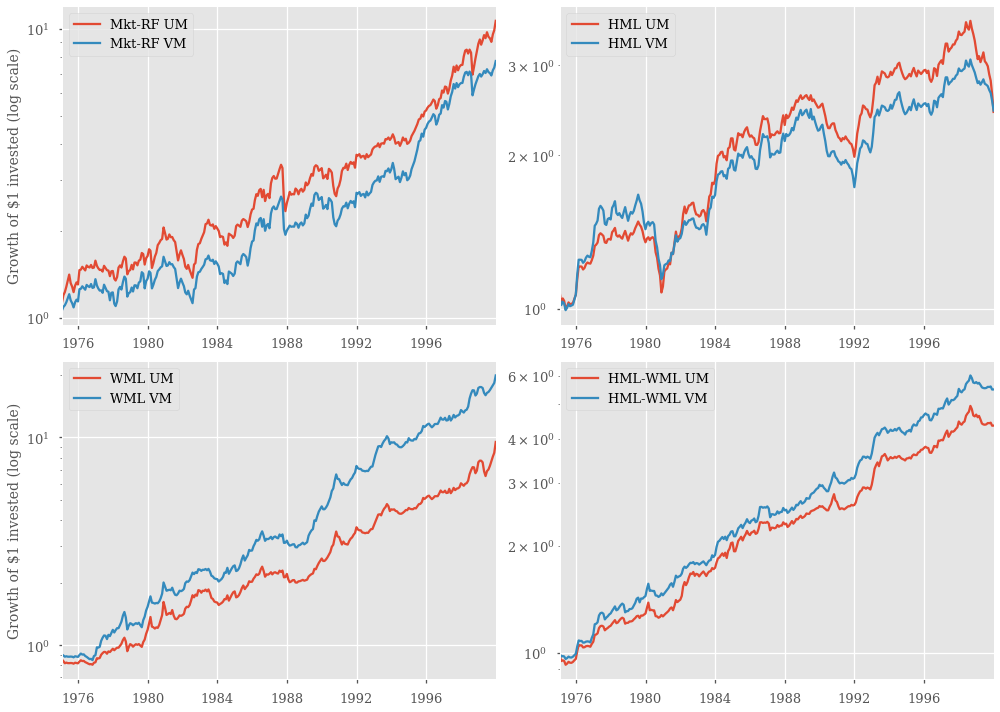

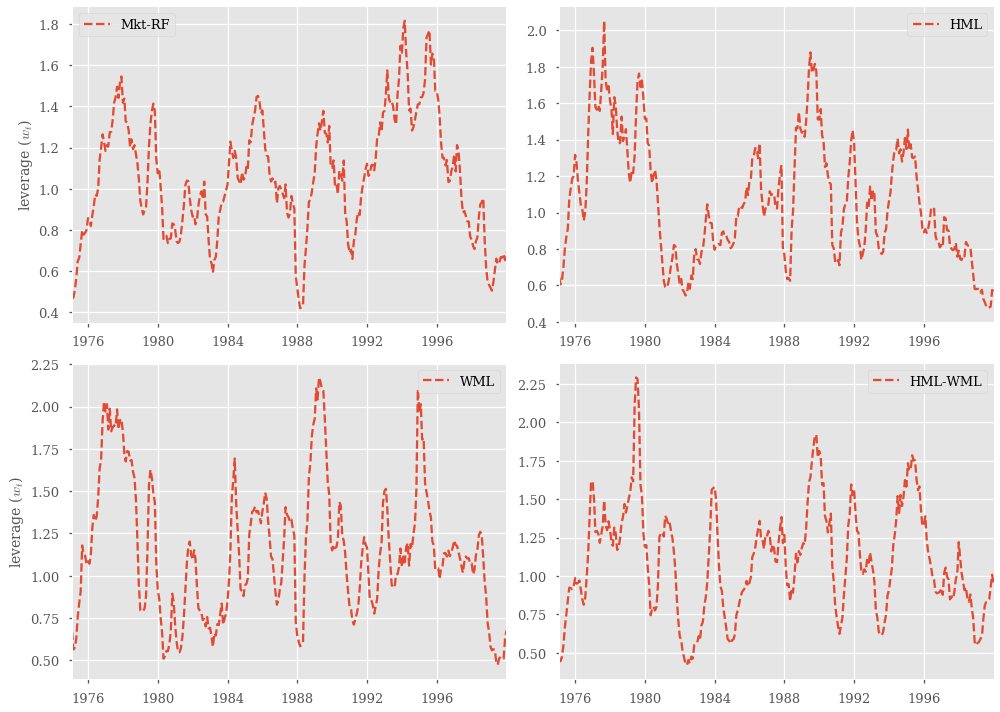

In [36]:
ys,ms,ds = 1975,1,1
ye,me,de = 1999,12,31

# subset returns and risk (predicted vol)
returns_99 = RETURNS.loc[datetime.date(year=ys,month=ms,day=ds):
                                     datetime.date(year=ye,month=me,day=de)]

risk_99 = VOL.loc[datetime.date(year=ys,month=ms,day=ds):
                                  datetime.date(year=ye,month=me,day=de)]

# get scaled portfolio
df_weights_ul_99, df_scaled_ul_99 = scaled_portfolio(returns=returns_99, 
                                                         risk=risk_99, max_weight=10)

# compare performance
plot_compare_return(df1=returns_99, df2=df_scaled_ul_99)
plot_weights(weights=df_weights_ul_99)
cp_ul99 = compare_perf_num(df1=df_scaled_ul_99, df2=returns_99, stat_CI=TEST_STAT)

# write to csv
write_to_csv(df_vm=df_scaled_ul_99,df_orig=returns_99,name="ul_1975-1999")

#store perormance
STORE_SUB_UL["99"] = cp_ul99

cp_ul99

#### 2000-2019

Complete


Portfolio           Mkt-RF                   HML                   WML  \
Position size     Constant Vol. managed Constant Vol. managed Constant   
N                  232.000      232.000  232.000      232.000  232.000   
Min                -17.179      -12.601  -11.322      -10.664  -26.971   
25 %                -1.952       -2.053   -1.337       -1.728   -1.421   
50 %                 1.073        1.300   -0.057       -0.091    0.469   
75 %                 3.221        3.591    1.754        2.015    2.787   
Max                 11.367       15.076   14.235       10.181   19.091   
Mean                 0.452        0.654    0.272        0.233    0.295   
SD                   4.355        4.355    3.176        3.176    5.223   
Skew                -0.629       -0.412    0.512        0.320   -0.652   
Kurtosis             0.971        0.396    3.204        0.835    5.362   
Terminal Wealth      2.278        3.647    1.673        1.527    1.433   
Mean (yr)            5.418        7.853    3.262        2.790    3.543   
SD (yr)             15.085       15.085   11.001       11.001   18.092   
SR (yr)              0.359        0.521    0.296        0.254    0.196   
SR                   0.104        0.150    0.086        0.073    0.057   
Kappa Ratio          0.103        0.162    0.095        0.085    0.050   
MDD (%)             54.211       42.167   32.374       46.358   56.562   
Calmar Ratio (yr)    0.100        0.186    0.101        0.060    0.063   
Max TUW (Year)      12.750        6.500   12.333       12.333   10.833   
Underwater (%)      80.603       79.741   84.052       83.190   93.966   
% MDD >20 %         38.362       29.310   22.414       60.776   64.224   
Diff SR              0.047        0.047   -0.012       -0.012    0.098   
Lower CI SR         -0.013       -0.013   -0.101       -0.101    0.023   
Upper CI SR          0.106        0.106    0.077        0.077    0.173   

Portfolio                       HML-WML               
Position size     Vol. managed Constant Vol. managed  
N                      232.000  232.000      232.000  
Min                    -21.964  -11.870       -8.873  
25 %                    -1.992   -0.809       -1.209  
50 %                     0.684    0.178        0.246  
75 %                     3.512    1.434        2.196  
Max                     22.917   15.294       10.304  
Mean                     0.809    0.277        0.392  
SD                       5.223    2.649        2.649  
Skew                     0.028    0.259        0.132  
Kurtosis                 2.289    7.101        0.982  
Terminal Wealth          4.745    1.752        2.288  
Mean (yr)                9.707    3.322        4.706  
SD (yr)                 18.092    9.175        9.175  
SR (yr)                  0.536    0.362        0.513  
SR                       0.155    0.104        0.148  
Kappa Ratio              0.170    0.102        0.174  
MDD (%)                 28.915   29.697       25.465  
Calmar Ratio (yr)        0.336    0.112        0.185  
Max TUW (Year)           3.167   10.500        8.083  
Underwater (%)          82.328   85.345       81.466  
% MDD >20 %             12.931   42.241        6.897  
Diff SR                  0.098    0.043        0.043  
Lower CI SR              0.023   -0.009       -0.009  
Upper CI SR              0.173    0.096        0.096

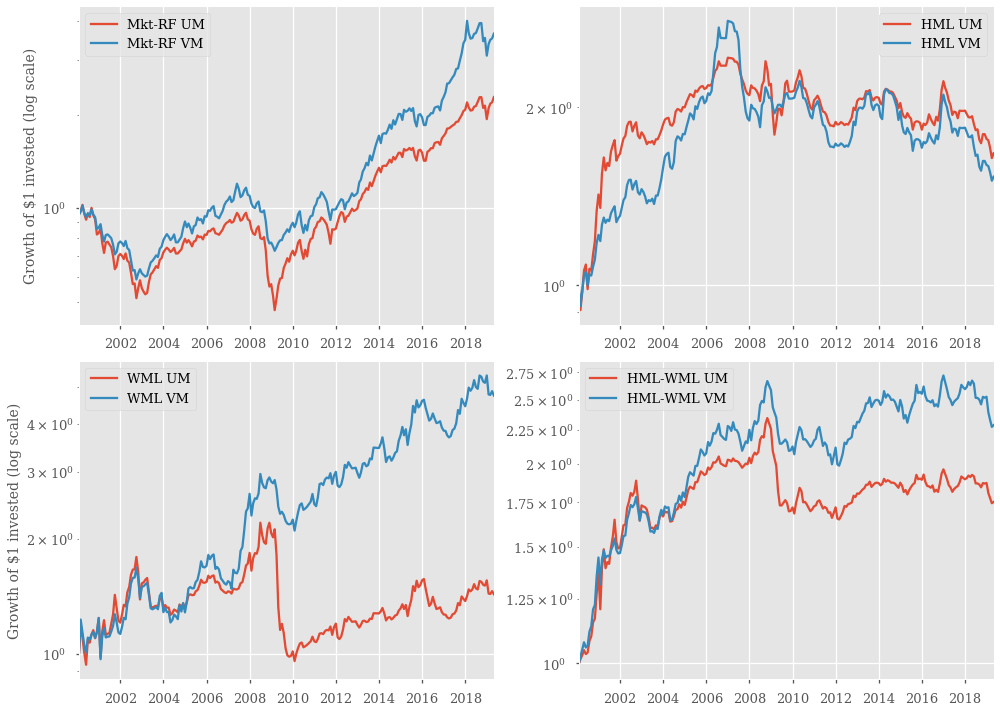

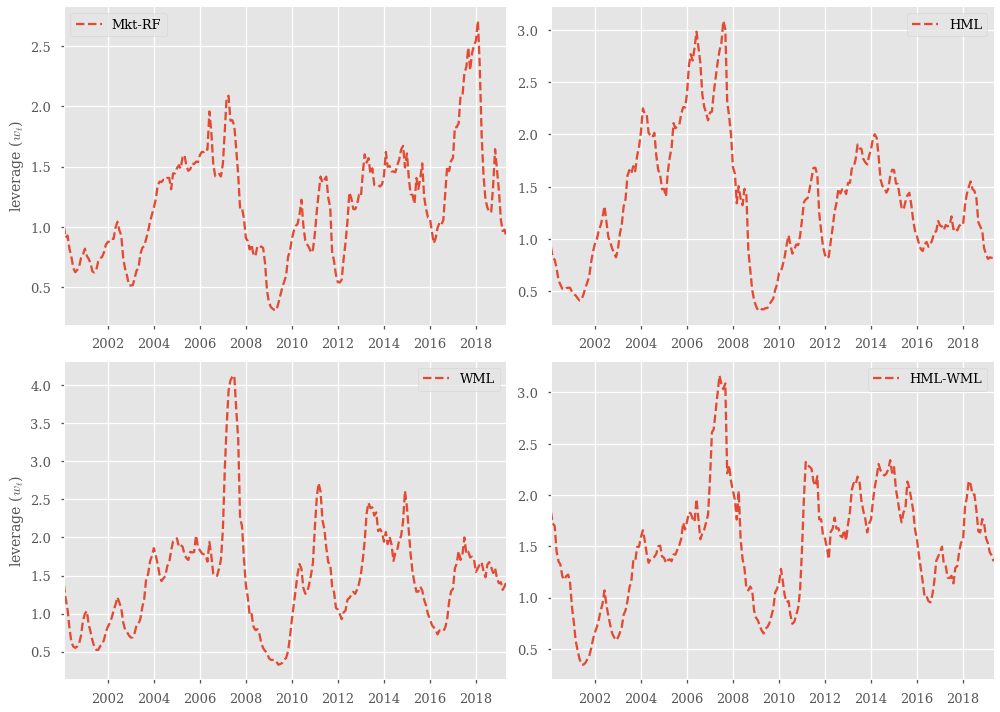

In [37]:
ys,ms,ds = 2000,1,1
ye,me,de = 2019,12,31

# subset returns and risk (predicted vol)
returns_2019 = RETURNS.loc[datetime.date(year=ys,month=ms,day=ds):
                                     datetime.date(year=ye,month=me,day=de)]

risk_2019 = VOL.loc[datetime.date(year=ys,month=ms,day=ds):
                                  datetime.date(year=ye,month=me,day=de)]

# get scaled portfolio
df_weights_ul_2019, df_scaled_ul_2019 = scaled_portfolio(returns=returns_2019, 
                                                         risk=risk_2019, max_weight=10)

# compare performance
plot_compare_return(df1=returns_2019, df2=df_scaled_ul_2019)
plot_weights(weights=df_weights_ul_2019)
cp_ul2019 = compare_perf_num(df1=df_scaled_ul_2019, df2=returns_2019, stat_CI=TEST_STAT)

# write to csv
write_to_csv(df_vm=df_scaled_ul_2019,df_orig=returns_2019,name="ul_2000-2019")

#store perormance
STORE_SUB_UL["2019"] = cp_ul2019

# store portfolios
cp_ul2019

**Add dictionary unlimited leverage to the main dictionary**

In [38]:
# add to the main dictionary
STORE_MAIN["unlimited_leverage"] = STORE_SUB_UL

## Limited leverage 
 - leverage max 1.5
 \begin{equation}
w_{t}=\min \left(\frac{\lambda}{\hat{\sigma}}, 1.5\right)
\end{equation}

 ### Full sample

In [39]:
MAX_WEIGHT = 1.5

Complete


Portfolio           Mkt-RF                   HML                   WML  \
Position size     Constant Vol. managed Constant Vol. managed Constant   
N                 1101.000     1101.000 1101.000     1101.000 1101.000   
Min                -29.122      -32.964  -13.035      -10.251  -29.816   
25 %                -1.997       -2.253   -1.282       -1.424   -1.114   
50 %                 1.019        1.131    0.141        0.176    0.668   
75 %                 3.587        4.038    1.741        2.022    2.766   
Max                 38.894       15.273   27.581       16.459   22.590   
Mean                 0.651        0.753    0.352        0.391    0.604   
SD                   5.349        5.003    3.321        2.978    4.391   
Skew                 0.201       -0.688    1.279        0.551   -0.927   
Kurtosis             7.960        2.753    9.527        1.512    8.524   
Terminal Wealth    264.982      955.215   26.644       45.410  254.933   
Mean (yr)            7.812        9.037    4.227        4.691    7.248   
SD (yr)             18.531       17.330   11.503       10.317   15.210   
SR (yr)              0.422        0.521    0.367        0.455    0.476   
SR                   0.122        0.150    0.106        0.131    0.138   
Kappa Ratio          0.120        0.146    0.124        0.165    0.117   
MDD (%)             84.631       61.869   43.358       36.636   69.199   
Calmar Ratio (yr)    0.092        0.146    0.098        0.128    0.105   
Max TUW (Year)      15.417       17.417   12.333       12.333   25.500   
Underwater (%)      78.928       79.382   81.925       82.652   83.560   
% MDD >20 %         35.695       39.964   13.624       12.262   39.600   
Diff SR              0.029        0.029    0.025        0.025    0.090   
Lower CI SR          0.000        0.000   -0.006       -0.006    0.055   
Upper CI SR          0.058        0.058    0.056        0.056    0.125   

Portfolio                       HML-WML               
Position size     Vol. managed Constant Vol. managed  
N                     1101.000 1101.000     1101.000  
Min                    -19.151  -11.870       -6.792  
25 %                    -1.237   -0.561       -0.617  
50 %                     0.759    0.380        0.435  
75 %                     3.196    1.516        1.699  
Max                     20.073   15.294       10.219  
Mean                     0.878    0.433        0.544  
SD                       3.862    2.237        2.023  
Skew                    -0.199   -0.128        0.300  
Kurtosis                 2.194    4.827        1.640  
Terminal Wealth       6742.461   89.018      314.942  
Mean (yr)               10.542    5.202        6.529  
SD (yr)                 13.380    7.748        7.008  
SR (yr)                  0.788    0.671        0.932  
SR                       0.227    0.194        0.269  
Kappa Ratio              0.247    0.195        0.339  
MDD (%)                 36.009   38.356       25.805  
Calmar Ratio (yr)        0.293    0.136        0.253  
Max TUW (Year)          11.167   10.500        8.000  
Underwater (%)          75.749   73.388       71.026  
% MDD >20 %              8.174   14.441        1.726  
Diff SR                  0.090    0.075        0.075  
Lower CI SR              0.055    0.046        0.046  
Upper CI SR              0.125    0.104        0.104

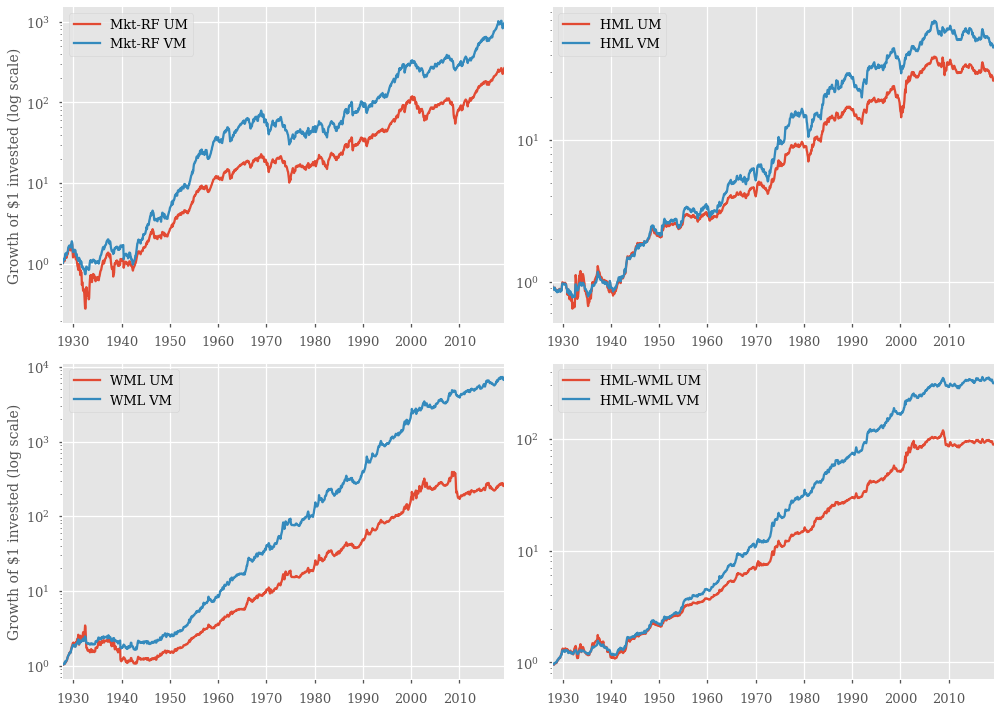

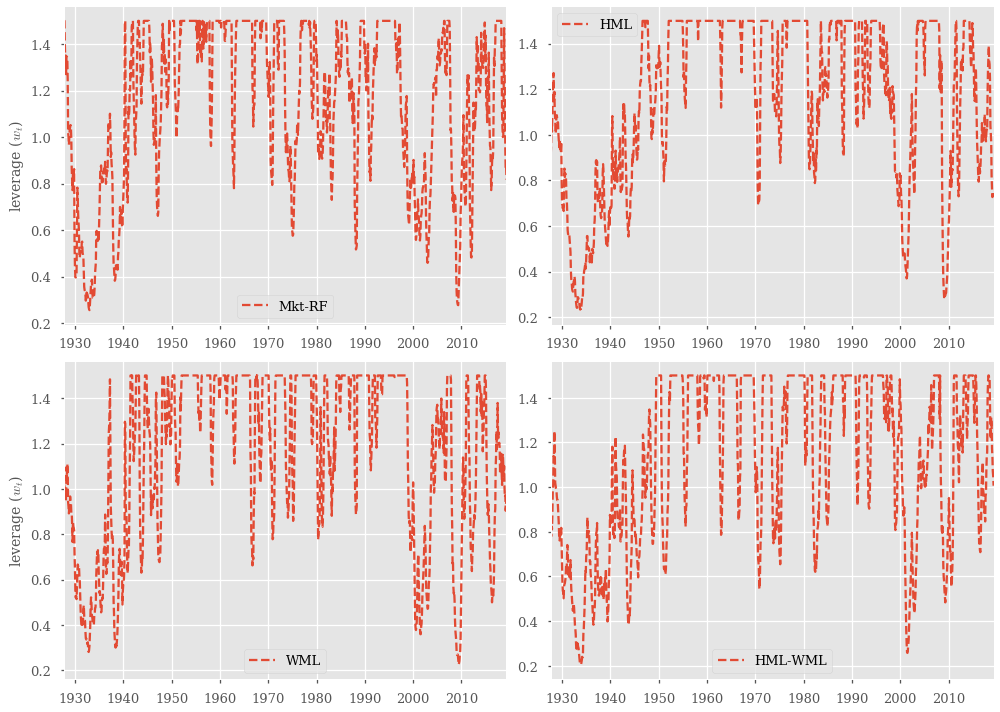

In [40]:
df_weights_ll, df_scaled_ll = scaled_portfolio(returns=RETURNS, risk=VOL, max_weight=MAX_WEIGHT)
plot_compare_return(df1=RETURNS, df2=df_scaled_ll)
plot_weights(weights=df_weights_ll)
cp_llfs = compare_perf_num(df1=df_scaled_ll, df2=RETURNS, stat_CI=TEST_STAT)

#store perormance
STORE_SUB_LL["full_sample"] = cp_llfs

# write to csv
write_to_csv(df_vm=df_scaled_ll,df_orig=RETURNS,name="ll_1927-2019")

# plot stats
cp_llfs

###  Subperiods
 
 - 1927-1949
 - 1950-1974
 - 1975-1999
 - 2000-2019
 
#### 1927-1949

Complete


Portfolio           Mkt-RF                   HML                   WML  \
Position size     Constant Vol. managed Constant Vol. managed Constant   
N                  269.000      269.000  269.000      269.000  269.000   
Min                -29.122      -32.964  -13.035       -9.005  -29.816   
25 %                -2.915       -3.008   -1.755       -1.787   -1.906   
50 %                 1.019        1.179    0.030        0.028    0.350   
75 %                 4.823        5.263    2.251        2.588    3.075   
Max                 38.894       20.003   27.581       22.167   22.590   
Mean                 0.677        0.876    0.391        0.498    0.328   
SD                   7.874        6.896    4.802        4.465    5.729   
Skew                 0.521       -0.673    1.483        1.058   -1.020   
Kurtosis             5.418        2.252    7.085        2.849    7.051   
Terminal Wealth      2.711        5.435    2.126        2.942    1.521   
Mean (yr)            8.120       10.516    4.691        5.977    3.939   
SD (yr)             27.277       23.887   16.636       15.467   19.845   
SR (yr)              0.298        0.440    0.282        0.387    0.199   
SR                   0.086        0.127    0.081        0.112    0.057   
Kappa Ratio          0.090        0.123    0.102        0.153    0.048   
MDD (%)             84.631       74.027   43.358       42.222   69.199   
Calmar Ratio (yr)    0.096        0.142    0.108        0.142    0.057   
Max TUW (Year)      15.417        7.417    5.833        6.833   17.583   
Underwater (%)      88.848       85.502   86.617       85.502   89.591   
% MDD >20 %         67.658       66.171   28.625       26.766   78.439   
Diff SR              0.041        0.041    0.030        0.030    0.050   
Lower CI SR         -0.013       -0.013   -0.018       -0.018    0.005   
Upper CI SR          0.095        0.095    0.079        0.079    0.094   

Portfolio                       HML-WML               
Position size     Vol. managed Constant Vol. managed  
N                      269.000  269.000      269.000  
Min                    -30.284  -10.461       -7.175  
25 %                    -2.138   -1.041       -1.105  
50 %                     0.397    0.293        0.295  
75 %                     3.515    1.949        2.010  
Max                     13.863    8.237       10.532  
Mean                     0.543    0.319        0.456  
SD                       5.086    2.720        2.623  
Skew                    -0.829   -0.370        0.304  
Kurtosis                 4.745    1.857        1.329  
Terminal Wealth          3.009    2.132        3.105  
Mean (yr)                6.522    3.826        5.472  
SD (yr)                 17.617    9.423        9.086  
SR (yr)                  0.370    0.406        0.602  
SR                       0.107    0.117        0.174  
Kappa Ratio              0.097    0.118        0.210  
MDD (%)                 53.240   38.356       37.468  
Calmar Ratio (yr)        0.122    0.100        0.146  
Max TUW (Year)          12.750    7.833        6.000  
Underwater (%)          89.219   82.528       80.297  
% MDD >20 %             62.082   22.677       17.844  
Diff SR                  0.050    0.057        0.057  
Lower CI SR              0.005    0.006        0.006  
Upper CI SR              0.094    0.107        0.107

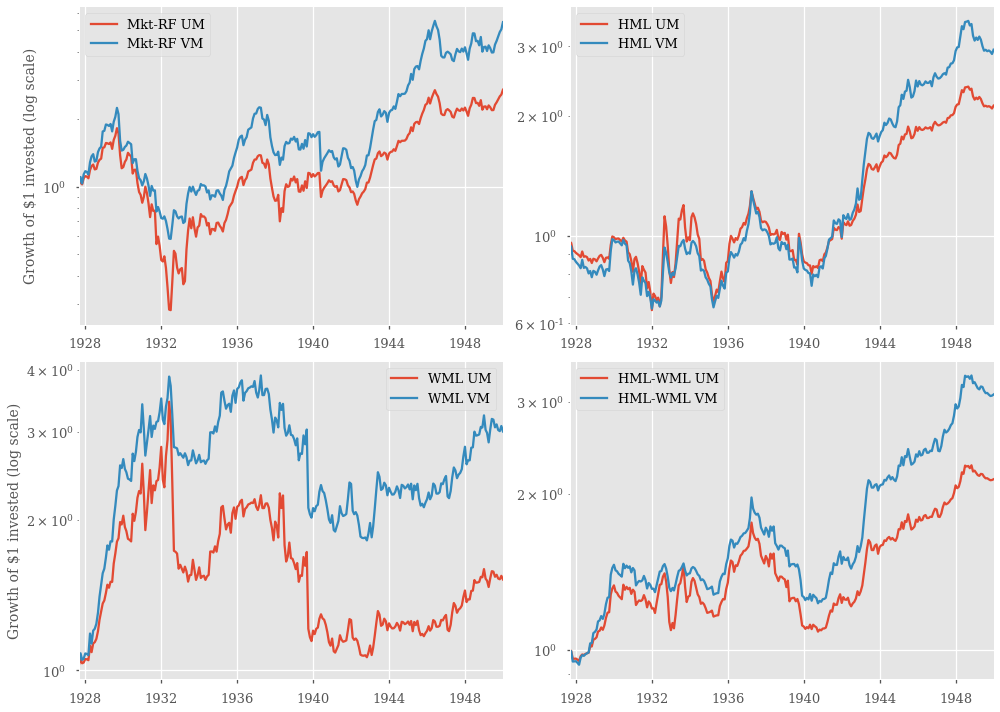

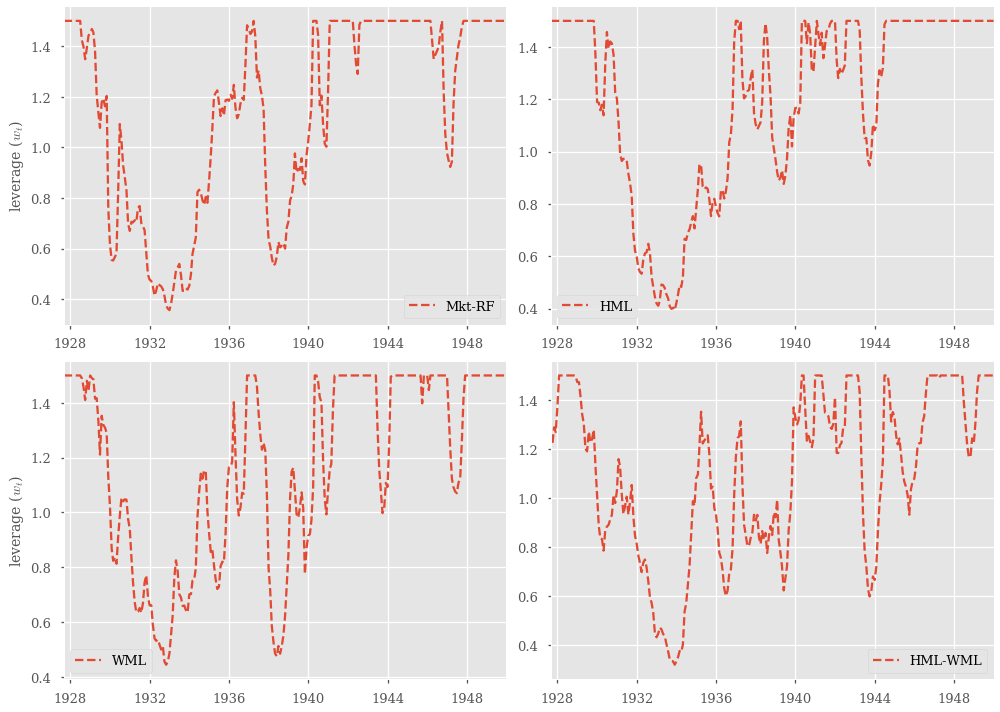

In [41]:
# get scaled portfolio
df_weights_ll_49, df_scaled_ll_49 = scaled_portfolio(returns=returns_49, 
                                                         risk=risk_49, max_weight=MAX_WEIGHT)

# compare performance
plot_compare_return(df1=returns_49, df2=df_scaled_ll_49)
plot_weights(weights=df_weights_ll_49)
cp_ll49 = compare_perf_num(df1=df_scaled_ll_49, df2=returns_49, stat_CI=TEST_STAT)

#store perormance
STORE_SUB_LL["49"] = cp_ll49
cp_ll49

# write to csv
write_to_csv(df_vm=df_scaled_ll_49,df_orig=returns_49,name="ll_1927-1949")

# plot stats
cp_ll49

#### 1950-1974

Complete


Portfolio           Mkt-RF                   HML                   WML  \
Position size     Constant Vol. managed Constant Vol. managed Constant   
N                  300.000      300.000  300.000      300.000  300.000   
Min                -12.720      -11.477   -8.664       -6.562  -11.123   
25 %                -1.904       -1.842   -0.853       -0.882   -0.723   
50 %                 0.759        0.840    0.275        0.284    1.030   
75 %                 3.111        3.396    1.557        1.728    2.584   
Max                 16.081       11.939   13.812       10.536   10.826   
Mean                 0.542        0.533    0.402        0.379    0.885   
SD                   3.925        3.857    2.301        2.297    3.000   
Skew                -0.286       -0.435    0.721        0.402   -0.232   
Kurtosis             0.916        0.129    4.299        1.226    1.787   
Terminal Wealth      4.021        3.938    3.079        2.881   12.303   
Mean (yr)            6.504        6.392    4.819        4.553   10.618   
SD (yr)             13.595       13.361    7.972        7.956   10.392   
SR (yr)              0.478        0.478    0.605        0.572    1.022   
SR                   0.138        0.138    0.174        0.165    0.295   
Kappa Ratio          0.148        0.148    0.214        0.207    0.331   
MDD (%)             55.528       50.438   17.937       19.976   16.988   
Calmar Ratio (yr)    0.117        0.127    0.269        0.228    0.625   
Max TUW (Year)       6.083        6.083    3.833        3.750    1.750   
Underwater (%)      68.667       74.000   77.333       77.000   59.333   
% MDD >20 %         12.000       25.000    0.000        0.000    0.000   
Diff SR              0.000        0.000   -0.009       -0.009    0.059   
Lower CI SR         -0.045       -0.045   -0.040       -0.040    0.030   
Upper CI SR          0.045        0.045    0.022        0.022    0.088   

Portfolio                       HML-WML               
Position size     Vol. managed Constant Vol. managed  
N                      300.000  300.000      300.000  
Min                     -9.335   -7.354       -5.107  
25 %                    -0.816   -0.318       -0.333  
50 %                     1.141    0.379        0.459  
75 %                     2.622    1.494        1.657  
Max                     10.019    7.245        7.783  
Mean                     1.034    0.584        0.670  
SD                       2.924    1.773        1.703  
Skew                    -0.038    0.139        0.512  
Kurtosis                 0.850    3.601        1.565  
Terminal Wealth         19.331    5.478        7.099  
Mean (yr)               12.413    7.009        8.037  
SD (yr)                 10.128    6.143        5.899  
SR (yr)                  1.226    1.141        1.363  
SR                       0.354    0.329        0.393  
Kappa Ratio              0.447    0.374        0.578  
MDD (%)                 12.137    9.034        5.910  
Calmar Ratio (yr)        1.023    0.776        1.360  
Max TUW (Year)           1.333    2.500        2.083  
Underwater (%)          57.000   60.000       57.333  
% MDD >20 %              0.000    0.000        0.000  
Diff SR                  0.059    0.064        0.064  
Lower CI SR              0.030    0.023        0.023  
Upper CI SR              0.088    0.104        0.104

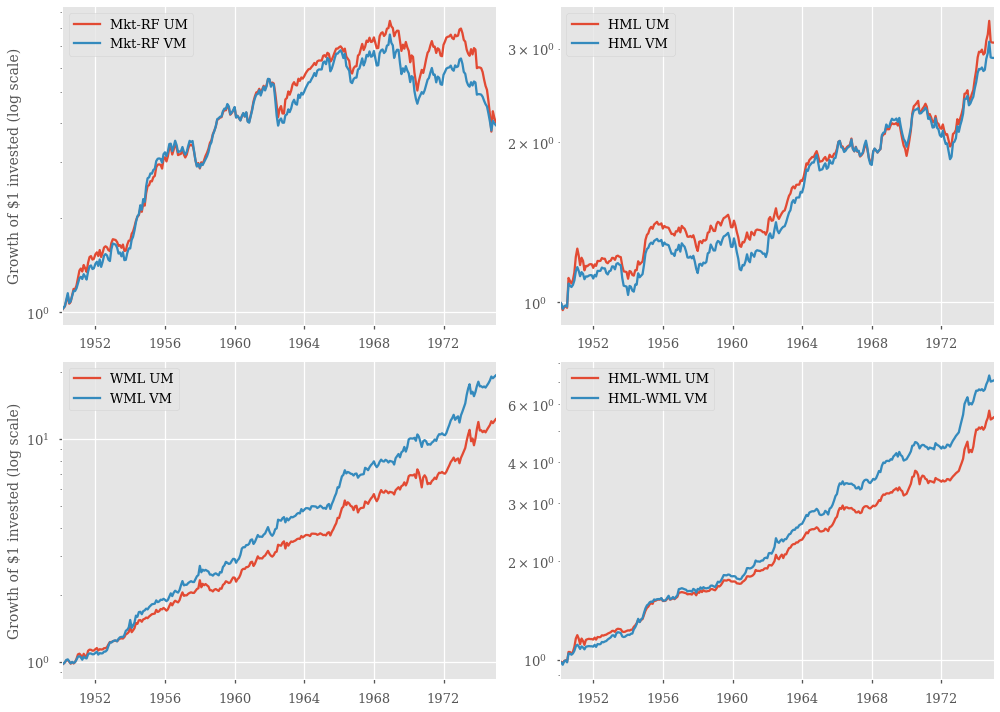

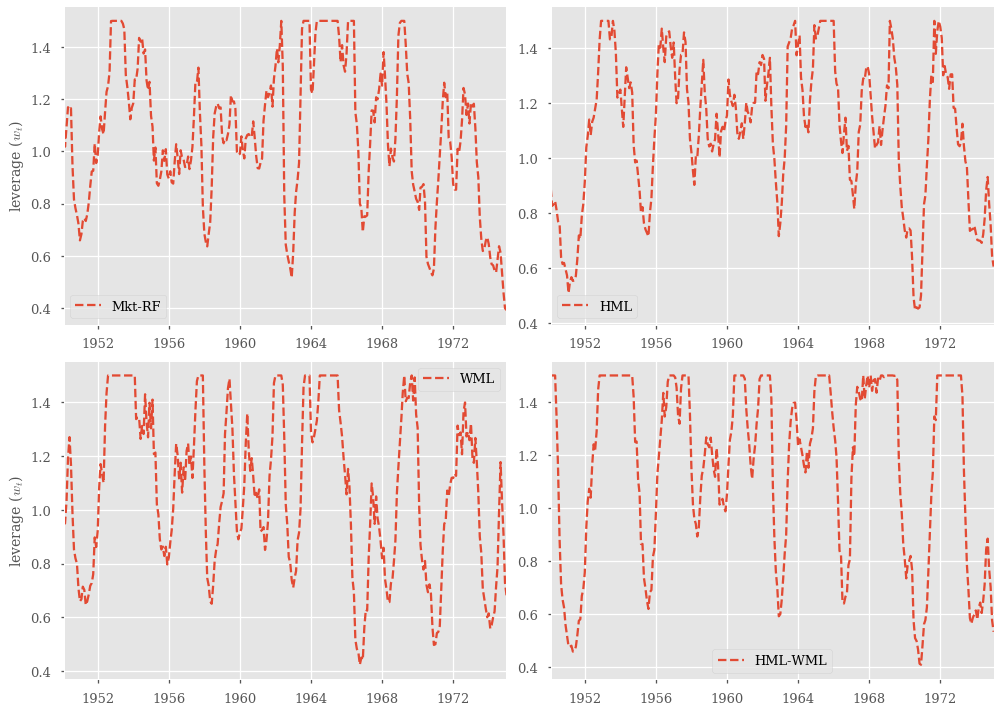

In [42]:
# get scaled portfolio
df_weights_ll_74, df_scaled_ll_74 = scaled_portfolio(returns=returns_74, 
                                                         risk=risk_74, max_weight=MAX_WEIGHT)

# compare performance
plot_compare_return(df1=returns_74, df2=df_scaled_ll_74)
plot_weights(weights=df_weights_ll_74)
cp_ll74 = compare_perf_num(df1=df_scaled_ll_74, df2=returns_74, stat_CI=TEST_STAT)

#store perormance
STORE_SUB_LL["74"] = cp_ll74

# write to csv
write_to_csv(df_vm=df_scaled_ll_74,df_orig=returns_74,name="ll_1950-1974")

# plot stats
cp_ll74

#### 1975-1999

Complete


Portfolio           Mkt-RF                   HML                   WML  \
Position size     Constant Vol. managed Constant Vol. managed Constant   
N                  300.000      300.000  300.000      300.000  300.000   
Min                -23.123      -20.913   -7.654       -7.056  -14.670   
25 %                -1.766       -1.867   -1.280       -1.311   -0.723   
50 %                 1.074        1.164    0.340        0.357    0.882   
75 %                 3.823        3.397    1.672        1.712    2.679   
Max                 13.307       12.384    7.844        9.704   15.658   
Mean                 0.891        0.777    0.331        0.334    0.809   
SD                   4.421        4.398    2.608        2.555    3.343   
Skew                -0.711       -0.683    0.208        0.309   -0.296   
Kurtosis             3.284        2.466    0.502        0.620    3.366   
Terminal Wealth     10.671        7.604    2.433        2.466    9.504   
Mean (yr)           10.697        9.319    3.966        4.004    9.710   
SD (yr)             15.315       15.235    9.034        8.851   11.581   
SR (yr)              0.699        0.612    0.439        0.452    0.839   
SR                   0.202        0.177    0.127        0.131    0.242   
Kappa Ratio          0.197        0.173    0.151        0.160    0.251   
MDD (%)             33.072       30.947   33.648       30.671   17.403   
Calmar Ratio (yr)    0.324        0.301    0.118        0.131    0.558   
Max TUW (Year)       3.667        2.500    3.833        4.167    3.083   
Underwater (%)      71.667       74.333   77.333       81.000   73.333   
% MDD >20 %          6.667        7.667    3.667        8.333    0.000   
Diff SR             -0.025       -0.025    0.004        0.004    0.065   
Lower CI SR         -0.058       -0.058   -0.036       -0.036    0.029   
Upper CI SR          0.008        0.008    0.044        0.044    0.101   

Portfolio                       HML-WML               
Position size     Vol. managed Constant Vol. managed  
N                      300.000  300.000      300.000  
Min                    -12.369   -5.520       -5.477  
25 %                    -0.760   -0.376       -0.451  
50 %                     0.904    0.594        0.610  
75 %                     2.900    1.382        1.397  
Max                     13.187    6.258        6.761  
Mean                     0.998    0.507        0.573  
SD                       3.249    1.774        1.755  
Skew                    -0.191   -0.067        0.129  
Kurtosis                 1.571    1.069        1.333  
Terminal Wealth         16.825    4.350        5.301  
Mean (yr)               11.974    6.083        6.873  
SD (yr)                 11.256    6.146        6.078  
SR (yr)                  1.064    0.990        1.131  
SR                       0.307    0.286        0.326  
Kappa Ratio              0.354    0.340        0.411  
MDD (%)                 17.612   12.026        8.707  
Calmar Ratio (yr)        0.680    0.506        0.789  
Max TUW (Year)           2.917    1.833        1.583  
Underwater (%)          70.000   65.000       64.000  
% MDD >20 %              0.000    0.000        0.000  
Diff SR                  0.065    0.041        0.041  
Lower CI SR              0.029    0.003        0.003  
Upper CI SR              0.101    0.078        0.078

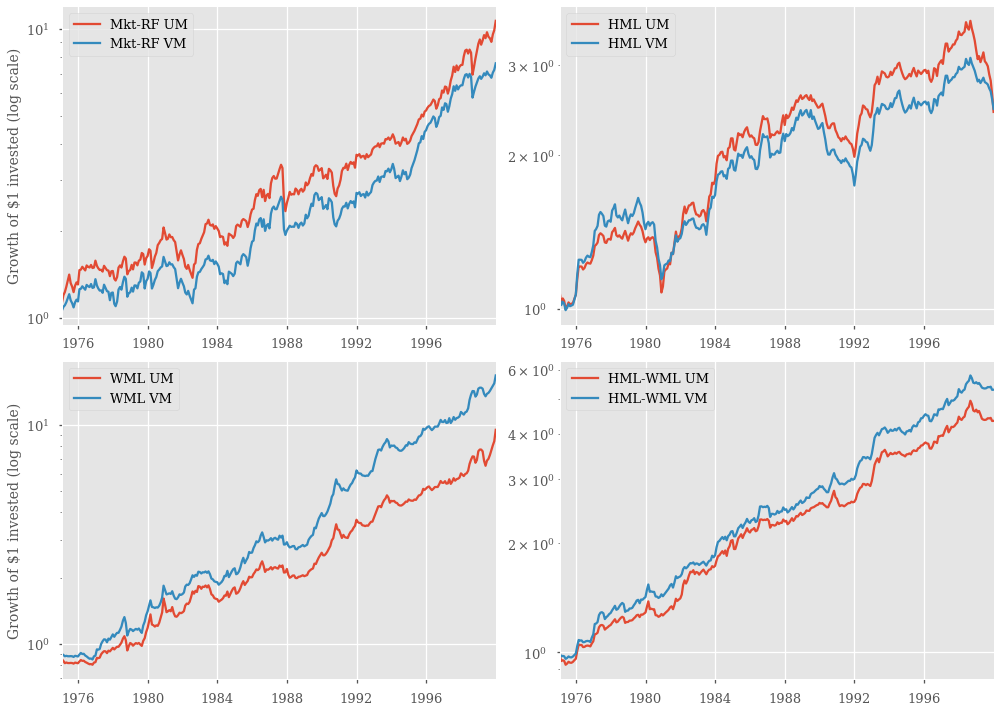

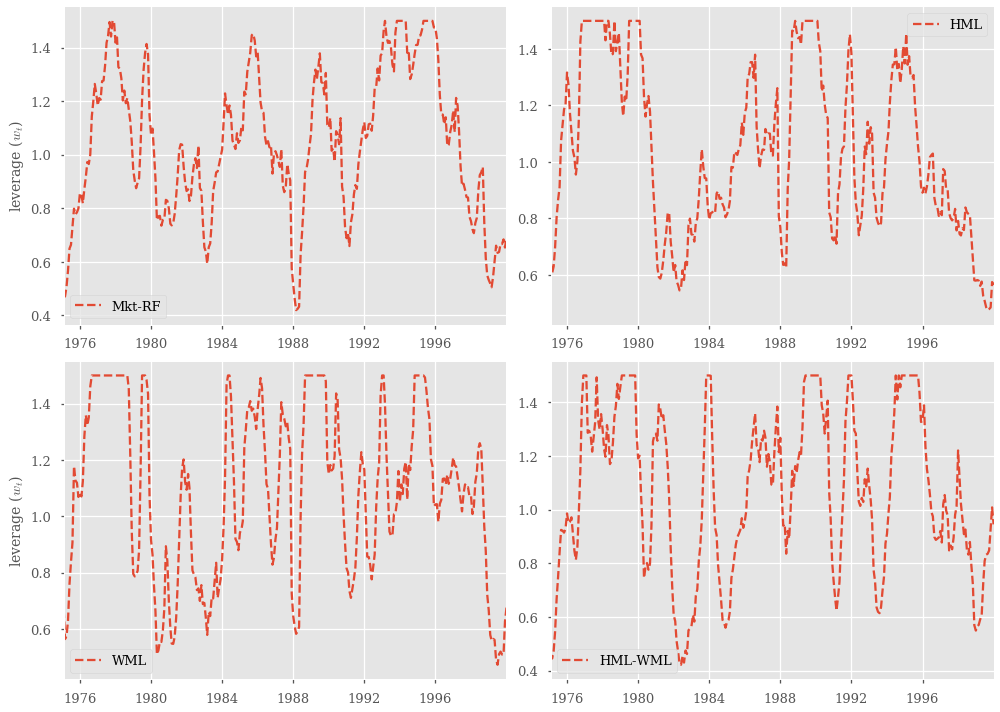

In [43]:
# get scaled portfolio
df_weights_ll_99, df_scaled_ll_99 = scaled_portfolio(returns=returns_99, 
                                                         risk=risk_99, max_weight=MAX_WEIGHT)

# compare performance
plot_compare_return(df1=returns_99, df2=df_scaled_ll_99)
plot_weights(weights=df_weights_ll_99)
cp_ll99 = compare_perf_num(df1=df_scaled_ll_99, df2=returns_99, stat_CI=TEST_STAT)

#store perormance
STORE_SUB_LL["99"] = cp_ll99

# write to csv
write_to_csv(df_vm=df_scaled_ll_99,df_orig=returns_99,name="ll_1975-1999")

# plot stats
cp_ll99

#### 2000-2019

Complete


Portfolio           Mkt-RF                   HML                   WML  \
Position size     Constant Vol. managed Constant Vol. managed Constant   
N                  232.000      232.000  232.000      232.000  232.000   
Min                -17.179      -12.354  -11.322       -7.130  -26.971   
25 %                -1.952       -2.053   -1.337       -1.683   -1.421   
50 %                 1.073        1.203   -0.057       -0.085    0.469   
75 %                 3.221        3.416    1.754        1.832    2.787   
Max                 11.367        8.895   14.235        9.252   19.091   
Mean                 0.452        0.586    0.272        0.197    0.295   
SD                   4.355        4.134    3.176        2.785    5.223   
Skew                -0.629       -0.549    0.512        0.384   -0.652   
Kurtosis             0.971        0.155    3.204        0.451    5.362   
Terminal Wealth      2.278        3.180    1.673        1.446    1.433   
Mean (yr)            5.418        7.031    3.262        2.367    3.543   
SD (yr)             15.085       14.319   11.001        9.647   18.092   
SR (yr)              0.359        0.491    0.296        0.245    0.196   
SR                   0.104        0.142    0.086        0.071    0.057   
Kappa Ratio          0.103        0.150    0.095        0.086    0.050   
MDD (%)             54.211       42.167   32.374       37.169   56.562   
Calmar Ratio (yr)    0.100        0.167    0.101        0.064    0.063   
Max TUW (Year)      12.750        6.500   12.333       12.333   10.833   
Underwater (%)      80.603       78.879   84.052       83.621   93.966   
% MDD >20 %         38.362       28.879   22.414       28.879   64.224   
Diff SR              0.038        0.038   -0.015       -0.015    0.072   
Lower CI SR         -0.015       -0.015   -0.081       -0.081    0.007   
Upper CI SR          0.091        0.091    0.052        0.052    0.137   

Portfolio                       HML-WML               
Position size     Vol. managed Constant Vol. managed  
N                      232.000  232.000      232.000  
Min                    -21.964  -11.870       -8.873  
25 %                    -1.893   -0.809       -1.012  
50 %                     0.636    0.178        0.246  
75 %                     3.302    1.434        1.952  
Max                     22.917   15.294       10.304  
Mean                     0.620    0.277        0.375  
SD                       4.822    2.649        2.468  
Skew                    -0.025    0.259        0.189  
Kurtosis                 3.506    7.101        1.795  
Terminal Wealth          3.207    1.752        2.223  
Mean (yr)                7.433    3.322        4.501  
SD (yr)                 16.702    9.175        8.550  
SR (yr)                  0.445    0.362        0.526  
SR                       0.129    0.104        0.152  
Kappa Ratio              0.133    0.102        0.175  
MDD (%)                 28.915   29.697       24.071  
Calmar Ratio (yr)        0.257    0.112        0.187  
Max TUW (Year)           3.833   10.500       10.500  
Underwater (%)          86.207   85.345       81.897  
% MDD >20 %             12.500   42.241        5.603  
Diff SR                  0.072    0.048        0.048  
Lower CI SR              0.007    0.004        0.004  
Upper CI SR              0.137    0.090        0.090

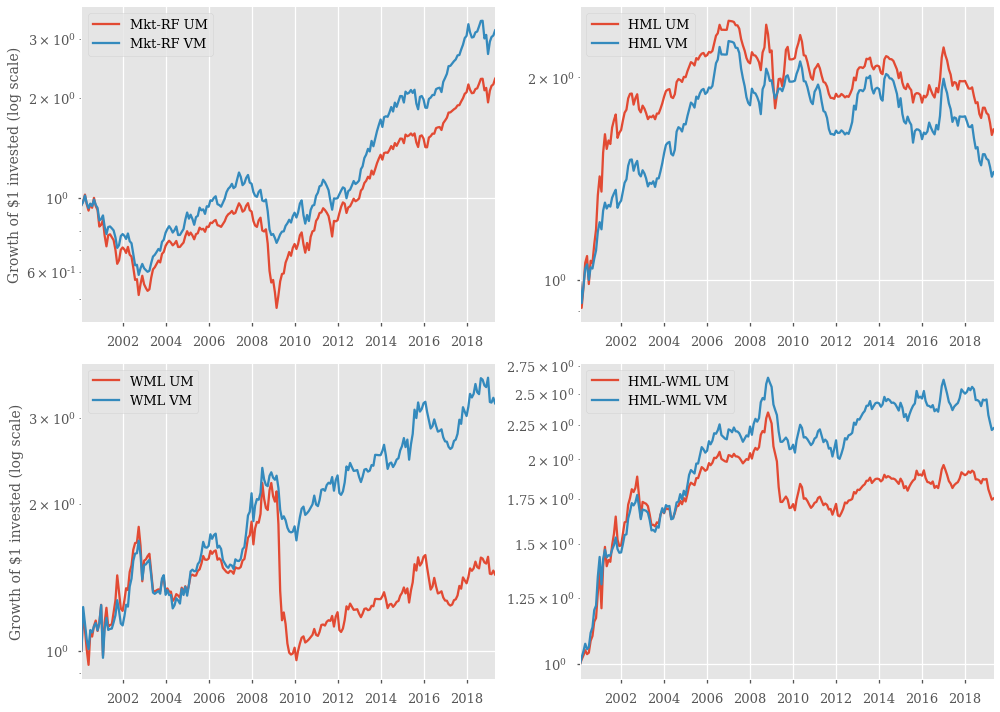

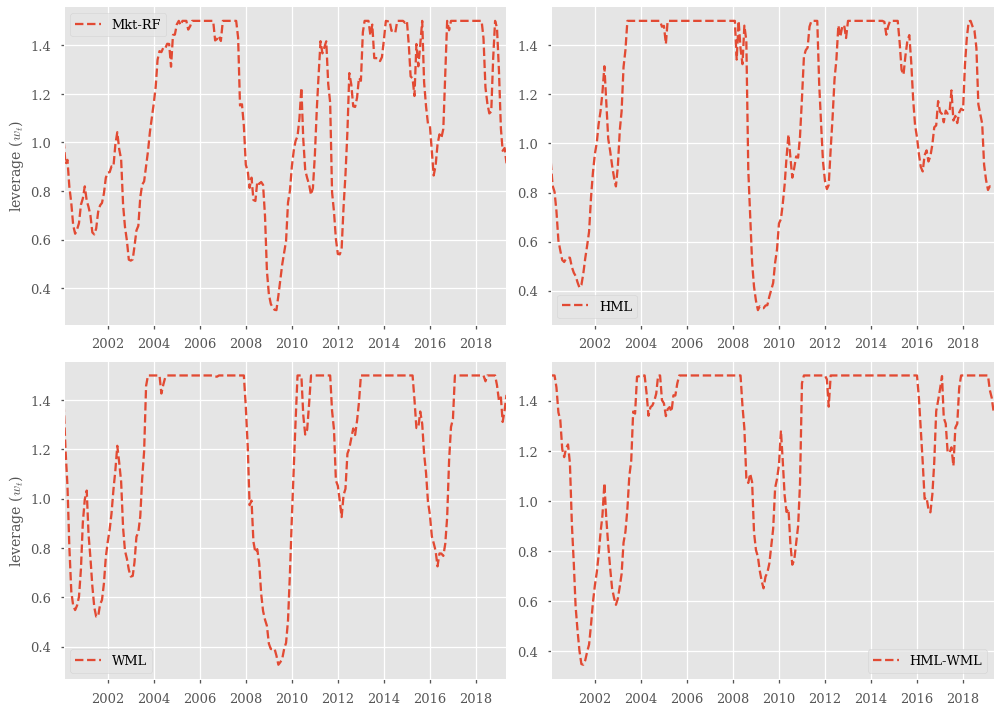

In [44]:
# get scaled portfolio
df_weights_ll_2019, df_scaled_ll_2019 = scaled_portfolio(returns=returns_2019, 
                                                         risk=risk_2019, max_weight=MAX_WEIGHT)

# compare performance
plot_compare_return(df1=returns_2019, df2=df_scaled_ll_2019)
plot_weights(weights=df_weights_ll_2019)
cp_ll2019 = compare_perf_num(df1=df_scaled_ll_2019, df2=returns_2019, stat_CI=TEST_STAT)

#store perormance
STORE_SUB_LL["2019"] = cp_ll2019

# write to csv
write_to_csv(df_vm=df_scaled_ll_2019,df_orig=returns_2019,name="ll_2000-2019")

# show stats
cp_ll2019

**Add dictionary limited leverage to the main dictionary**

In [45]:
# add to the main dictionary
STORE_MAIN["limited_leverage"] = STORE_SUB_LL

### Influence leverage on SR
   - maybe better on out of sample data

In [46]:
SR_list = [f"Diff {TEST_STAT}",f"Lower CI {TEST_STAT}", f"Upper CI {TEST_STAT}"]

max_weights = [10,3,2.5,2,1.5,1]
inf_lev_list = []
for i in max_weights:
    df_w, df_sc = scaled_portfolio(returns=RETURNS, 
                                   risk=VOL, max_weight=i)
    #print(f'max allowed weight {i}, got:{df_w.max()}')
    inf_lev_list.append(compare_perf_num(df1=RETURNS.multiply(df_w), 
                                         df2=RETURNS,stats=SR_list, boots=100))

In [47]:
out = pd.concat(inf_lev_list)
index = pd.MultiIndex.from_product([max_weights,[f"Diff {TEST_STAT}", 
                                                 f"Lower CI {TEST_STAT}",
                                                 f"Upper CI {TEST_STAT}"]],
                                       names=["Max Weight", "CI"])
pd.DataFrame(out.values,index=index, columns=out.columns)

Portfolio                Mkt-RF                   HML                   WML  \
Position size          Constant Vol. managed Constant Vol. managed Constant   
Max Weight CI                                                                 
10.000     Diff SR        0.028        0.028    0.021        0.021    0.116   
           Lower CI SR   -0.007       -0.007   -0.016       -0.016    0.075   
           Upper CI SR    0.062        0.062    0.057        0.057    0.156   
3.000      Diff SR        0.027        0.027    0.021        0.021    0.115   
           Lower CI SR   -0.004       -0.004   -0.011       -0.011    0.073   
           Upper CI SR    0.059        0.059    0.051        0.051    0.157   
2.500      Diff SR        0.028        0.028    0.021        0.021    0.113   
           Lower CI SR   -0.004       -0.004   -0.010       -0.010    0.073   
           Upper CI SR    0.059        0.059    0.052        0.052    0.152   
2.000      Diff SR        0.029        0.029    0.023        0.023    0.108   
           Lower CI SR   -0.002       -0.002   -0.016       -0.016    0.069   
           Upper CI SR    0.059        0.059    0.061        0.061    0.146   
1.500      Diff SR        0.029        0.029    0.025        0.025    0.090   
           Lower CI SR    0.002        0.002   -0.002       -0.002    0.054   
           Upper CI SR    0.056        0.056    0.053        0.053    0.125   
1.000      Diff SR        0.024        0.024    0.021        0.021    0.061   
           Lower CI SR    0.000        0.000   -0.004       -0.004    0.027   
           Upper CI SR    0.047        0.047    0.046        0.046    0.095   

Portfolio                            HML-WML               
Position size          Vol. managed Constant Vol. managed  
Max Weight CI                                              
10.000     Diff SR            0.116    0.087        0.087  
           Lower CI SR        0.075    0.054        0.054  
           Upper CI SR        0.156    0.121        0.121  
3.000      Diff SR            0.115    0.087        0.087  
           Lower CI SR        0.073    0.056        0.056  
           Upper CI SR        0.157    0.119        0.119  
2.500      Diff SR            0.113    0.086        0.086  
           Lower CI SR        0.073    0.056        0.056  
           Upper CI SR        0.152    0.117        0.117  
2.000      Diff SR            0.108    0.084        0.084  
           Lower CI SR        0.069    0.053        0.053  
           Upper CI SR        0.146    0.114        0.114  
1.500      Diff SR            0.090    0.075        0.075  
           Lower CI SR        0.054    0.046        0.046  
           Upper CI SR        0.125    0.104        0.104  
1.000      Diff SR            0.061    0.053        0.053  
           Lower CI SR        0.027    0.032        0.032  
           Upper CI SR        0.095    0.074        0.074

## Influence of the target vol

**Influence of the choice of  the chosen target volatility (todo: make figure to illustrate)**

In [48]:
# influence of the lambda or target volatility
out = pd.DataFrame({i:RETURNS.loc[:,"Mkt-RF"].multiply(i/VOL.loc[:,"Mkt-RF"]) for i in [0.1,1]})
perf_stat(df=out, all_stats=True, dic_perf=PERF_STAT_DIC)

0.100    1.000
N                 1101.000 1101.000
Min                 -4.751  -47.511
25 %                -0.332   -3.322
50 %                 0.169    1.689
75 %                 0.571    5.708
Max                  2.470   24.701
Mean                 0.109    1.092
SD                   0.732    7.317
Skew                -0.669   -0.669
Kurtosis             2.529    2.529
Terminal Wealth      3.227 7518.694
Mean (yr)            1.310   13.099
SD (yr)              2.535   25.346
SR (yr)              0.517    0.517
SR                   0.149    0.149
Kappa Ratio          0.146    0.146
MDD (%)             12.797   79.954
Calmar Ratio (yr)    0.102    0.164
Max TUW (Year)      17.167   24.000
Underwater (%)      78.837   83.288
% MDD >20 %          0.000   53.043

## Summarize results by portfolio

**global parameters**

In [49]:
# global names
PERIODS = ["Full Sample","1927-1949","1950-1974","1975-1999","2000-2019"]
SUB_INDEX = ["UL","LL"]
NAMES = ["Period","Leverage"]

In [50]:
def find_portfolio(dic=None, portfolio=None, strategy=None, names=None):
    
    out = {}
    for key, value in dic.items():    

        out[f"{portfolio}_{key}"] = value[portfolio][strategy]
    
    if names is not None:
        out = pd.DataFrame(out.values,index=out.index,columns=names)
    
    return out

In [51]:
def compare_perf_2(df1=None, df2=None, upper_index=None, sub_index=None, names = None):
    
    create_df = True
    for c in df1.columns:
    
        if create_df:
            x = pd.DataFrame(df1[c].values,columns=[f"df1 {c}"],index=df1.index)
            create_df=False
        else:
            x[f"df1{c}"] = df1[c]

        x[f"df2{c}"] = df2[c]

        cols = pd.MultiIndex.from_product([upper_index,
                                        sub_index],
                                       names=["Portfolio", "Position size"])

    compare_performance = pd.DataFrame(x.values, index=x.index, columns=cols)
    return compare_performance

## Market portfolio (Mkt-RF)

### Original results

In [52]:
mkt_orig = pd.DataFrame(find_portfolio(dic=STORE_MAIN["unlimited_leverage"], 
                   portfolio="Mkt-RF", strategy="Constant"))

mkt_orig
#print(mkt_orig.loc[METRICS_THESIS,:].to_latex())

Mkt-RF_full_sample  Mkt-RF_49  Mkt-RF_74  Mkt-RF_99  \
N                            1101.000    269.000    300.000    300.000   
Min                           -29.122    -29.122    -12.720    -23.123   
25 %                           -1.997     -2.915     -1.904     -1.766   
50 %                            1.019      1.019      0.759      1.074   
75 %                            3.587      4.823      3.111      3.823   
Max                            38.894     38.894     16.081     13.307   
Mean                            0.651      0.677      0.542      0.891   
SD                              5.349      7.874      3.925      4.421   
Skew                            0.201      0.521     -0.286     -0.711   
Kurtosis                        7.960      5.418      0.916      3.284   
Terminal Wealth               264.982      2.711      4.021     10.671   
Mean (yr)                       7.812      8.120      6.504     10.697   
SD (yr)                        18.531     27.277     13.595     15.315   
SR (yr)                         0.422      0.298      0.478      0.699   
SR                              0.122      0.086      0.138      0.202   
Kappa Ratio                     0.120      0.090      0.148      0.197   
MDD (%)                        84.631     84.631     55.528     33.072   
Calmar Ratio (yr)               0.092      0.096      0.117      0.324   
Max TUW (Year)                 15.417     15.417      6.083      3.667   
Underwater (%)                 78.928     88.848     68.667     71.667   
% MDD >20 %                    35.695     67.658     12.000      6.667   
Diff SR                         0.028      0.052     -0.002     -0.024   
Lower CI SR                    -0.006     -0.018     -0.045     -0.057   
Upper CI SR                     0.061      0.122      0.043      0.008   

                   Mkt-RF_2019  
N                      232.000  
Min                    -17.179  
25 %                    -1.952  
50 %                     1.073  
75 %                     3.221  
Max                     11.367  
Mean                     0.452  
SD                       4.355  
Skew                    -0.629  
Kurtosis                 0.971  
Terminal Wealth          2.278  
Mean (yr)                5.418  
SD (yr)                 15.085  
SR (yr)                  0.359  
SR                       0.104  
Kappa Ratio              0.103  
MDD (%)                 54.211  
Calmar Ratio (yr)        0.100  
Max TUW (Year)          12.750  
Underwater (%)          80.603  
% MDD >20 %             38.362  
Diff SR                  0.047  
Lower CI SR             -0.013  
Upper CI SR              0.106

### Vol. Managed portfolio
   - unlimited levearge (UL)
   - limited leverage (LL)

In [53]:
ul_mkt = pd.DataFrame(find_portfolio(dic=STORE_MAIN["unlimited_leverage"], 
                   portfolio="Mkt-RF", strategy="Vol. managed"))

ll_mkt = pd.DataFrame(find_portfolio(dic=STORE_MAIN["limited_leverage"], 
                   portfolio="Mkt-RF", strategy="Vol. managed"))

out_compare_perf_mkt = compare_perf_2(df1=ul_mkt, df2=ll_mkt, 
             upper_index=PERIODS, sub_index=SUB_INDEX, names = NAMES)

out_compare_perf_mkt
#print(out_compare_perf_mkt.loc[METRICS_THESIS,:].to_latex())

Portfolio         Full Sample          1927-1949         1950-1974          \
Position size              UL       LL        UL      LL        UL      LL   
N                    1101.000 1101.000   269.000 269.000   300.000 300.000   
Min                   -34.736  -32.964   -48.470 -32.964   -11.477 -11.477   
25 %                   -2.429   -2.253    -3.610  -3.008    -1.940  -1.842   
50 %                    1.235    1.131     1.191   1.179     0.856   0.840   
75 %                    4.173    4.038     5.730   5.263     3.410   3.396   
Max                    18.059   15.273    20.003  20.003    11.939  11.939   
Mean                    0.798    0.753     1.088   0.876     0.536   0.533   
SD                      5.349    5.003     7.874   6.896     3.925   3.857   
Skew                   -0.669   -0.688    -1.019  -0.673    -0.446  -0.435   
Kurtosis                2.529    2.753     5.343   2.252     0.172   0.129   
Terminal Wealth      1276.455  955.215     7.573   5.435     3.948   3.938   
Mean (yr)               9.577    9.037    13.054  10.516     6.434   6.392   
SD (yr)                18.531   17.330    27.277  23.887    13.595  13.361   
SR (yr)                 0.517    0.521     0.479   0.440     0.473   0.478   
SR                      0.149    0.150     0.138   0.127     0.137   0.138   
Kappa Ratio             0.146    0.146     0.124   0.123     0.146   0.148   
MDD (%)                67.401   61.869    74.027  74.027    50.797  50.438   
Calmar Ratio (yr)       0.142    0.146     0.176   0.142     0.127   0.127   
Max TUW (Year)         18.500   17.417     7.417   7.417     6.083   6.083   
Underwater (%)         81.290   79.382    86.617  85.502    74.333  74.000   
% MDD >20 %            42.053   39.964    67.658  66.171    25.333  25.000   
Diff SR                 0.028    0.029     0.052   0.041    -0.002   0.000   
Lower CI SR            -0.006    0.000    -0.018  -0.013    -0.045  -0.045   
Upper CI SR             0.061    0.058     0.122   0.095     0.043   0.045   

Portfolio         1975-1999         2000-2019          
Position size            UL      LL        UL      LL  
N                   300.000 300.000   232.000 232.000  
Min                 -20.913 -20.913   -12.601 -12.354  
25 %                 -1.867  -1.867    -2.053  -2.053  
50 %                  1.164   1.164     1.300   1.203  
75 %                  3.397   3.397     3.591   3.416  
Max                  12.384  12.384    15.076   8.895  
Mean                  0.784   0.777     0.654   0.586  
SD                    4.421   4.398     4.355   4.134  
Skew                 -0.678  -0.683    -0.412  -0.549  
Kurtosis              2.390   2.466     0.396   0.155  
Terminal Wealth       7.744   7.604     3.647   3.180  
Mean (yr)             9.404   9.319     7.853   7.031  
SD (yr)              15.315  15.235    15.085  14.319  
SR (yr)               0.614   0.612     0.521   0.491  
SR                    0.177   0.177     0.150   0.142  
Kappa Ratio           0.174   0.173     0.162   0.150  
MDD (%)              30.947  30.947    42.167  42.167  
Calmar Ratio (yr)     0.304   0.301     0.186   0.167  
Max TUW (Year)        2.500   2.500     6.500   6.500  
Underwater (%)       74.333  74.333    79.741  78.879  
% MDD >20 %           7.667   7.667    29.310  28.879  
Diff SR              -0.024  -0.025     0.047   0.038  
Lower CI SR          -0.057  -0.058    -0.013  -0.015  
Upper CI SR           0.008   0.008     0.106   0.091

## Value portfolio (HML)

### Original results

In [54]:
hml_orig = pd.DataFrame(find_portfolio(dic=STORE_MAIN["unlimited_leverage"], 
                   portfolio="HML", strategy="Constant"))
hml_orig
#print(hml_orig.loc[METRICS_THESIS,:].to_latex())

HML_full_sample  HML_49  HML_74  HML_99  HML_2019
N                         1101.000 269.000 300.000 300.000   232.000
Min                        -13.035 -13.035  -8.664  -7.654   -11.322
25 %                        -1.282  -1.755  -0.853  -1.280    -1.337
50 %                         0.141   0.030   0.275   0.340    -0.057
75 %                         1.741   2.251   1.557   1.672     1.754
Max                         27.581  27.581  13.812   7.844    14.235
Mean                         0.352   0.391   0.402   0.331     0.272
SD                           3.321   4.802   2.301   2.608     3.176
Skew                         1.279   1.483   0.721   0.208     0.512
Kurtosis                     9.527   7.085   4.299   0.502     3.204
Terminal Wealth             26.644   2.126   3.079   2.433     1.673
Mean (yr)                    4.227   4.691   4.819   3.966     3.262
SD (yr)                     11.503  16.636   7.972   9.034    11.001
SR (yr)                      0.367   0.282   0.605   0.439     0.296
SR                           0.106   0.081   0.174   0.127     0.086
Kappa Ratio                  0.124   0.102   0.214   0.151     0.095
MDD (%)                     43.358  43.358  17.937  33.648    32.374
Calmar Ratio (yr)            0.098   0.108   0.269   0.118     0.101
Max TUW (Year)              12.333   5.833   3.833   3.833    12.333
Underwater (%)              81.925  86.617  77.333  77.333    84.052
% MDD >20 %                 13.624  28.625   0.000   3.667    22.414
Diff SR                      0.021   0.039  -0.009   0.001    -0.012
Lower CI SR                 -0.015  -0.014  -0.041  -0.043    -0.101
Upper CI SR                  0.056   0.092   0.023   0.044     0.077

### Vol. Managed portfolio
   - unlimited levearge (UL)
   - limited leverage (LL)

In [55]:
ul_hml = pd.DataFrame(find_portfolio(dic=STORE_MAIN["unlimited_leverage"], 
                   portfolio="HML", strategy="Vol. managed"))

ll_hml = pd.DataFrame(find_portfolio(dic=STORE_MAIN["limited_leverage"], 
                   portfolio="HML", strategy="Vol. managed"))

out_compar_perf_hml = compare_perf_2(df1=ul_hml, df2=ll_hml, 
             upper_index=PERIODS, sub_index=SUB_INDEX, names = NAMES)

out_compar_perf_hml
#print(out_compar_perf_hml.loc[METRICS_THESIS,:].to_latex())

Portfolio         Full Sample          1927-1949         1950-1974          \
Position size              UL       LL        UL      LL        UL      LL   
N                    1101.000 1101.000   269.000 269.000   300.000 300.000   
Min                   -10.251  -10.251   -10.177  -9.005    -6.562  -6.562   
25 %                   -1.555   -1.424    -2.030  -1.787    -0.882  -0.882   
50 %                    0.186    0.176     0.028   0.028     0.284   0.284   
75 %                    2.188    2.022     2.920   2.588     1.728   1.728   
Max                    16.459   16.459    22.167  22.167    10.536  10.536   
Mean                    0.420    0.391     0.579   0.498     0.382   0.379   
SD                      3.321    2.978     4.802   4.465     2.301   2.297   
Skew                    0.456    0.551     0.917   1.058     0.400   0.402   
Kurtosis                1.246    1.512     1.964   2.849     1.201   1.226   
Terminal Wealth        55.732   45.410     3.504   2.942     2.902   2.881   
Mean (yr)               5.043    4.691     6.944   5.977     4.583   4.553   
SD (yr)                11.503   10.317    16.636  15.467     7.972   7.956   
SR (yr)                 0.438    0.455     0.417   0.387     0.575   0.572   
SR                      0.127    0.131     0.120   0.112     0.166   0.165   
Kappa Ratio             0.156    0.165     0.166   0.153     0.208   0.207   
MDD (%)                42.761   36.636    43.255  42.222    20.014  19.976   
Calmar Ratio (yr)       0.118    0.128     0.161   0.142     0.229   0.228   
Max TUW (Year)         12.333   12.333     6.833   6.833     3.750   3.750   
Underwater (%)         83.106   82.652    84.758  85.502    77.000  77.000   
% MDD >20 %            21.798   12.262    29.368  26.766     0.333   0.000   
Diff SR                 0.021    0.025     0.039   0.030    -0.009  -0.009   
Lower CI SR            -0.015   -0.006    -0.014  -0.018    -0.041  -0.040   
Upper CI SR             0.056    0.056     0.092   0.079     0.023   0.022   

Portfolio         1975-1999         2000-2019          
Position size            UL      LL        UL      LL  
N                   300.000 300.000   232.000 232.000  
Min                  -7.056  -7.056   -10.664  -7.130  
25 %                 -1.317  -1.311    -1.728  -1.683  
50 %                  0.361   0.357    -0.091  -0.085  
75 %                  1.712   1.712     2.015   1.832  
Max                   9.704   9.704    10.181   9.252  
Mean                  0.333   0.334     0.233   0.197  
SD                    2.608   2.555     3.176   2.785  
Skew                  0.290   0.309     0.320   0.384  
Kurtosis              0.618   0.620     0.835   0.451  
Terminal Wealth       2.448   2.466     1.527   1.446  
Mean (yr)             3.990   4.004     2.790   2.367  
SD (yr)               9.034   8.851    11.001   9.647  
SR (yr)               0.442   0.452     0.254   0.245  
SR                    0.128   0.131     0.073   0.071  
Kappa Ratio           0.155   0.160     0.085   0.086  
MDD (%)              31.667  30.671    46.358  37.169  
Calmar Ratio (yr)     0.126   0.131     0.060   0.064  
Max TUW (Year)        4.417   4.167    12.333  12.333  
Underwater (%)       82.000  81.000    83.190  83.621  
% MDD >20 %           9.333   8.333    60.776  28.879  
Diff SR               0.001   0.004    -0.012  -0.015  
Lower CI SR          -0.043  -0.036    -0.101  -0.081  
Upper CI SR           0.044   0.044     0.077   0.052

## Momentum portfolio (WML)

### Original results

In [56]:
wml_orig = pd.DataFrame(find_portfolio(dic=STORE_MAIN["unlimited_leverage"], 
                   portfolio="WML", strategy="Constant"))
wml_orig
#print(wml_orig.loc[METRICS_THESIS,:].to_latex())

WML_full_sample  WML_49  WML_74  WML_99  WML_2019
N                         1101.000 269.000 300.000 300.000   232.000
Min                        -29.816 -29.816 -11.123 -14.670   -26.971
25 %                        -1.114  -1.906  -0.723  -0.723    -1.421
50 %                         0.668   0.350   1.030   0.882     0.469
75 %                         2.766   3.075   2.584   2.679     2.787
Max                         22.590  22.590  10.826  15.658    19.091
Mean                         0.604   0.328   0.885   0.809     0.295
SD                           4.391   5.729   3.000   3.343     5.223
Skew                        -0.927  -1.020  -0.232  -0.296    -0.652
Kurtosis                     8.524   7.051   1.787   3.366     5.362
Terminal Wealth            254.933   1.521  12.303   9.504     1.433
Mean (yr)                    7.248   3.939  10.618   9.710     3.543
SD (yr)                     15.210  19.845  10.392  11.581    18.092
SR (yr)                      0.476   0.199   1.022   0.839     0.196
SR                           0.138   0.057   0.295   0.242     0.057
Kappa Ratio                  0.117   0.048   0.331   0.251     0.050
MDD (%)                     69.199  69.199  16.988  17.403    56.562
Calmar Ratio (yr)            0.105   0.057   0.625   0.558     0.063
Max TUW (Year)              25.500  17.583   1.750   3.083    10.833
Underwater (%)              83.560  89.591  59.333  73.333    93.966
% MDD >20 %                 39.600  78.439   0.000   0.000    64.224
Diff SR                      0.116   0.058   0.060   0.074     0.098
Lower CI SR                  0.076   0.006   0.027   0.036     0.023
Upper CI SR                  0.155   0.110   0.093   0.112     0.173

### Vol. Managed portfolio
   - unlimited levearge (UL)
   - limited leverage (LL)

In [57]:
ul_wml = pd.DataFrame(find_portfolio(dic=STORE_MAIN["unlimited_leverage"], 
                   portfolio="WML", strategy="Vol. managed"))

ll_wml = pd.DataFrame(find_portfolio(dic=STORE_MAIN["limited_leverage"], 
                   portfolio="WML", strategy="Vol. managed"))

out_compare_perf_wml = compare_perf_2(df1=ul_wml, df2=ll_wml, 
             upper_index=PERIODS, sub_index=SUB_INDEX, names = NAMES)

out_compare_perf_wml
#print(out_compare_perf_wml.loc[METRICS_THESIS,:].to_latex())

Portfolio         Full Sample          1927-1949         1950-1974          \
Position size              UL       LL        UL      LL        UL      LL   
N                    1101.000 1101.000   269.000 269.000   300.000 300.000   
Min                   -19.151  -19.151   -30.284 -30.284    -9.335  -9.335   
25 %                   -1.313   -1.237    -2.700  -2.138    -0.816  -0.816   
50 %                    0.827    0.759     0.539   0.397     1.169   1.141   
75 %                    3.598    3.196     3.882   3.515     2.692   2.622   
Max                    20.073   20.073    14.407  13.863    10.019  10.019   
Mean                    1.112    0.878     0.659   0.543     1.065   1.034   
SD                      4.391    3.862     5.729   5.086     3.000   2.924   
Skew                   -0.023   -0.199    -0.540  -0.829    -0.040  -0.038   
Kurtosis                1.761    2.194     2.865   4.745     0.860   0.850   
Terminal Wealth     68063.356 6742.461     3.737   3.009    21.047  19.331   
Mean (yr)              13.339   10.542     7.904   6.522    12.783  12.413   
SD (yr)                15.210   13.380    19.845  17.617    10.392  10.128   
SR (yr)                 0.877    0.788     0.398   0.370     1.230   1.226   
SR                      0.253    0.227     0.115   0.107     0.355   0.354   
Kappa Ratio             0.291    0.247     0.111   0.097     0.449   0.447   
MDD (%)                36.009   36.009    53.445  53.240    12.137  12.137   
Calmar Ratio (yr)       0.370    0.293     0.148   0.122     1.053   1.023   
Max TUW (Year)         11.167   11.167    11.667  12.750     1.333   1.333   
Underwater (%)         74.114   75.749    88.848  89.219    57.000  57.000   
% MDD >20 %             8.901    8.174    55.762  62.082     0.000   0.000   
Diff SR                 0.116    0.090     0.058   0.050     0.060   0.059   
Lower CI SR             0.076    0.055     0.006   0.005     0.027   0.030   
Upper CI SR             0.155    0.125     0.110   0.094     0.093   0.088   

Portfolio         1975-1999         2000-2019          
Position size            UL      LL        UL      LL  
N                   300.000 300.000   232.000 232.000  
Min                 -12.369 -12.369   -21.964 -21.964  
25 %                 -0.760  -0.760    -1.992  -1.893  
50 %                  0.970   0.904     0.684   0.636  
75 %                  2.946   2.900     3.512   3.302  
Max                  13.187  13.187    22.917  22.917  
Mean                  1.056   0.998     0.809   0.620  
SD                    3.343   3.249     5.223   4.822  
Skew                 -0.117  -0.191     0.028  -0.025  
Kurtosis              1.409   1.571     2.289   3.506  
Terminal Wealth      19.853  16.825     4.745   3.207  
Mean (yr)            12.678  11.974     9.707   7.433  
SD (yr)              11.581  11.256    18.092  16.702  
SR (yr)               1.095   1.064     0.536   0.445  
SR                    0.316   0.307     0.155   0.129  
Kappa Ratio           0.374   0.354     0.170   0.133  
MDD (%)              17.612  17.612    28.915  28.915  
Calmar Ratio (yr)     0.720   0.680     0.336   0.257  
Max TUW (Year)        2.750   2.917     3.167   3.833  
Underwater (%)       69.333  70.000    82.328  86.207  
% MDD >20 %           0.000   0.000    12.931  12.500  
Diff SR               0.074   0.065     0.098   0.072  
Lower CI SR           0.036   0.029     0.023   0.007  
Upper CI SR           0.112   0.101     0.173   0.137

## Value-Momentum portfolio (HML-WML)

### Original results

In [58]:
hml_wml_orig = pd.DataFrame(find_portfolio(dic=STORE_MAIN["unlimited_leverage"], 
                   portfolio="HML-WML", strategy="Constant"))
hml_wml_orig
#print(hml_wml_orig.loc[METRICS_THESIS,:].to_latex())

HML-WML_full_sample  HML-WML_49  HML-WML_74  HML-WML_99  \
N                             1101.000     269.000     300.000     300.000   
Min                            -11.870     -10.461      -7.354      -5.520   
25 %                            -0.561      -1.041      -0.318      -0.376   
50 %                             0.380       0.293       0.379       0.594   
75 %                             1.516       1.949       1.494       1.382   
Max                             15.294       8.237       7.245       6.258   
Mean                             0.433       0.319       0.584       0.507   
SD                               2.237       2.720       1.773       1.774   
Skew                            -0.128      -0.370       0.139      -0.067   
Kurtosis                         4.827       1.857       3.601       1.069   
Terminal Wealth                 89.018       2.132       5.478       4.350   
Mean (yr)                        5.202       3.826       7.009       6.083   
SD (yr)                          7.748       9.423       6.143       6.146   
SR (yr)                          0.671       0.406       1.141       0.990   
SR                               0.194       0.117       0.329       0.286   
Kappa Ratio                      0.195       0.118       0.374       0.340   
MDD (%)                         38.356      38.356       9.034      12.026   
Calmar Ratio (yr)                0.136       0.100       0.776       0.506   
Max TUW (Year)                  10.500       7.833       2.500       1.833   
Underwater (%)                  73.388      82.528      60.000      65.000   
% MDD >20 %                     14.441      22.677       0.000       0.000   
Diff SR                          0.087       0.061       0.072       0.044   
Lower CI SR                      0.056       0.005       0.027       0.006   
Upper CI SR                      0.119       0.116       0.116       0.082   

                   HML-WML_2019  
N                       232.000  
Min                     -11.870  
25 %                     -0.809  
50 %                      0.178  
75 %                      1.434  
Max                      15.294  
Mean                      0.277  
SD                        2.649  
Skew                      0.259  
Kurtosis                  7.101  
Terminal Wealth           1.752  
Mean (yr)                 3.322  
SD (yr)                   9.175  
SR (yr)                   0.362  
SR                        0.104  
Kappa Ratio               0.102  
MDD (%)                  29.697  
Calmar Ratio (yr)         0.112  
Max TUW (Year)           10.500  
Underwater (%)           85.345  
% MDD >20 %              42.241  
Diff SR                   0.043  
Lower CI SR              -0.009  
Upper CI SR               0.096

### Vol. Managed portfolio
   - unlimited levearge (UL)
   - limited leverage (LL)

In [59]:
ul_hml_wml = pd.DataFrame(find_portfolio(dic=STORE_MAIN["unlimited_leverage"], 
                   portfolio="HML-WML", strategy="Vol. managed"))

ll_hml_wml = pd.DataFrame(find_portfolio(dic=STORE_MAIN["limited_leverage"],  
                   portfolio="HML-WML", strategy="Vol. managed"))

compare_perf_hml_wml = compare_perf_2(df1=ul_hml_wml, df2=ll_hml_wml, 
             upper_index=PERIODS, sub_index=SUB_INDEX, names = NAMES)

compare_perf_hml_wml
#print(compare_perf_hml_wml.loc[METRICS_THESIS,:].to_latex())

Portfolio         Full Sample          1927-1949         1950-1974          \
Position size              UL       LL        UL      LL        UL      LL   
N                    1101.000 1101.000   269.000 269.000   300.000 300.000   
Min                    -8.053   -6.792    -7.175  -7.175    -5.107  -5.107   
25 %                   -0.696   -0.617    -1.132  -1.105    -0.356  -0.333   
50 %                    0.470    0.435     0.353   0.295     0.460   0.459   
75 %                    1.907    1.699     2.010   2.010     1.731   1.657   
Max                    10.350   10.219    10.532  10.532     7.783   7.783   
Mean                    0.629    0.544     0.484   0.456     0.711   0.670   
SD                      2.237    2.023     2.720   2.623     1.773   1.703   
Skew                    0.369    0.300     0.338   0.304     0.503   0.512   
Kurtosis                1.537    1.640     1.097   1.329     1.217   1.565   
Terminal Wealth       761.614  314.942     3.322   3.105     8.006   7.099   
Mean (yr)               7.551    6.529     5.806   5.472     8.535   8.037   
SD (yr)                 7.748    7.008     9.423   9.086     6.143   5.899   
SR (yr)                 0.975    0.932     0.616   0.602     1.389   1.363   
SR                      0.281    0.269     0.178   0.174     0.401   0.393   
Kappa Ratio             0.365    0.339     0.220   0.210     0.604   0.578   
MDD (%)                25.805   25.805    37.698  37.468     5.910   5.910   
Calmar Ratio (yr)       0.293    0.253     0.154   0.146     1.444   1.360   
Max TUW (Year)          8.000    8.000     6.000   6.000     2.083   2.083   
Underwater (%)         70.572   71.026    79.926  80.297    57.000  57.333   
% MDD >20 %             1.726    1.726    17.844  17.844     0.000   0.000   
Diff SR                 0.087    0.075     0.061   0.057     0.072   0.064   
Lower CI SR             0.056    0.046     0.005   0.006     0.027   0.023   
Upper CI SR             0.119    0.104     0.116   0.107     0.116   0.104   

Portfolio         1975-1999         2000-2019          
Position size            UL      LL        UL      LL  
N                   300.000 300.000   232.000 232.000  
Min                  -5.477  -5.477    -8.873  -8.873  
25 %                 -0.451  -0.451    -1.209  -1.012  
50 %                  0.613   0.610     0.246   0.246  
75 %                  1.449   1.397     2.196   1.952  
Max                   6.766   6.761    10.304  10.304  
Mean                  0.585   0.573     0.392   0.375  
SD                    1.774   1.755     2.649   2.468  
Skew                  0.107   0.129     0.132   0.189  
Kurtosis              1.214   1.333     0.982   1.795  
Terminal Wealth       5.498   5.301     2.288   2.223  
Mean (yr)             7.024   6.873     4.706   4.501  
SD (yr)               6.146   6.078     9.175   8.550  
SR (yr)               1.143   1.131     0.513   0.526  
SR                    0.330   0.326     0.148   0.152  
Kappa Ratio           0.417   0.411     0.174   0.175  
MDD (%)               8.707   8.707    25.465  24.071  
Calmar Ratio (yr)     0.807   0.789     0.185   0.187  
Max TUW (Year)        1.583   1.583     8.083  10.500  
Underwater (%)       64.000  64.000    81.466  81.897  
% MDD >20 %           0.000   0.000     6.897   5.603  
Diff SR               0.044   0.041     0.043   0.048  
Lower CI SR           0.006   0.003    -0.009   0.004  
Upper CI SR           0.082   0.078     0.096   0.090

## Out of sample results, target volatility estimated based on previous data
  - use an expanding window to estimate the target level
  - choose the target volatility a priori:
  - general target level of 12 % for all portfolios

In [60]:
# store results
STORE_OUTPUT_OS = {}
# store VM portfolios for R
PATH_DATA_2=("C:\\Users\\Pieter-Jan\\Documents\\Factor_Crashes\\Code"
"\\Simulation\\VM_portfolios\\out_of_sample\\Monthly_Simple\\")
STEPS = 1 # update every month
WINDOW = 10*FREQUENCY # 10 years
TARGET_VOL = 12/np.sqrt(FREQUENCY)

In [61]:
def get_target_level_managed(risk=None, returns=None, 
                     target=None, steps=1, 
                     span=None, max_weight=10):
    
    store_target_vol = []
    for i in range(0,len(returns[span:]),steps):
        out = target_vol(target=target, returns=returns[0+i:span+i], 
                 risk=risk[0+i:span+i], max_weight=max_weight)
        store_target_vol+=[out]*steps
        
    return store_target_vol

In [62]:
def target_dataframe_managed(df_returns=None, 
                     df_risk=None, 
                     target=None, 
                     span=None, steps=None, 
                     max_weight=10):
    """
        loop over all portfolios and put everything in a dataframe
    """
    store_target_dic = {}
    for c in df_returns.columns:
        
        t= df_returns[c][span:].std() if target is None else target
        
        store_target_dic[c] = get_target_level_managed(risk=df_risk[c], returns=df_returns[c], 
                                               target=t, steps=steps, span=span, 
                                               max_weight=max_weight)
    
    len_data = len(df_returns.index[span:])
    x = pd.DataFrame(store_target_dic)[:len_data]
    df_target = pd.DataFrame(x.values, columns=df_returns.columns,
             index=df_returns.index[span:])
    
    return df_target 

#### Constant vol original unmanaged portfolios for comparison


In [63]:
constant_vol_um_dic = {}
for c in RETURNS.columns:
        w = TARGET_VOL/RETURNS[c][WINDOW:].std()
        constant_vol_um_dic[c] = RETURNS[c][WINDOW:].multiply(w)
constant_vol_um_df = pd.DataFrame(constant_vol_um_dic)

In [64]:
descript_const_vol_um = perf_stat(df=constant_vol_um_df, 
                                  all_stats=True, 
                                  dic_perf=PERF_STAT_DIC)

descript_const_vol_um
# print((descript_const_vol_um.loc[METRICS_THESIS,:].dropna()).to_latex())

Mkt-RF     HML     WML  HML-WML
N                 981.000 981.000 981.000  981.000
Min               -18.344 -14.148 -25.612  -19.524
25 %               -1.488  -1.461  -0.900   -0.862
50 %                0.781   0.245   0.555    0.625
75 %                2.679   2.119   2.274    2.427
Max                18.420  24.314  19.405   25.156
Mean                0.496   0.446   0.491    0.708
SD                  3.464   3.464   3.464    3.464
Skew               -0.540   0.673  -0.869   -0.047
Kurtosis            3.230   4.366   9.100    5.643
Terminal Wealth    70.733  44.033  66.788  564.368
Mean (yr)           5.948   5.347   5.886    8.494
SD (yr)            12.000  12.000  12.000   12.000
SR (yr)             0.496   0.446   0.491    0.708
SR                  0.143   0.129   0.142    0.204
Kappa Ratio         0.139   0.150   0.121    0.207
MDD (%)            45.558  47.160  50.609   48.355
Calmar Ratio (yr)   0.131   0.113   0.116    0.176
Max TUW (Year)     12.417  12.333  16.000   10.500
Underwater (%)     75.943  80.122  81.448   73.394
% MDD >20 %        15.596  15.087  30.071   19.164

Complete
Complete


Portfolio             Mkt-RF             HML              WML           \
$\lambda$ estimation      IS     OOS      IS     OOS       IS      OOS   
N                    981.000 981.000 981.000 981.000  981.000  981.000   
Min                  -22.431 -24.285 -10.524 -11.367  -14.752  -18.988   
25 %                  -1.560  -1.576  -1.589  -1.633   -1.058   -1.163   
50 %                   0.827   0.857   0.309   0.294    0.668    0.720   
75 %                   2.726   2.869   2.331   2.341    2.822    2.875   
Max                   11.662  12.361  16.898  22.235   15.462   16.420   
Mean                   0.524   0.541   0.469   0.457    0.886    0.886   
SD                     3.464   3.513   3.464   3.492    3.464    3.529   
Skew                  -0.714  -0.759   0.405   0.552   -0.024   -0.078   
Kurtosis               2.713   3.075   1.199   2.071    1.716    2.013   
Terminal Wealth       93.349 108.307  55.377  48.559 3205.134 3124.135   
Mean (yr)              6.292   6.496   5.631   5.479   10.630   10.627   
SD (yr)               12.000  12.171  12.000  12.097   12.000   12.226   
SR (yr)                0.524   0.534   0.469   0.453    0.886    0.869   
SR                     0.151   0.154   0.136   0.131    0.256    0.251   
Kappa Ratio            0.147   0.148   0.166   0.162    0.294    0.284   
MDD (%)               49.911  45.454  43.641  49.832   24.518   30.990   
Calmar Ratio (yr)      0.126   0.143   0.129   0.110    0.434    0.343   
Max TUW (Year)        17.500  17.250  12.333  12.333   10.250   10.750   
Underwater (%)        79.409  79.409  81.346  81.346   73.496   73.496   
% MDD >20 %           25.076  25.484  22.834  22.732    2.650    4.179   
Diff SR                0.008   0.011   0.007   0.002    0.114    0.109   
Lower CI SR           -0.023  -0.018  -0.024  -0.029    0.075    0.070   
Upper CI SR            0.039   0.040   0.038   0.034    0.153    0.149   

Portfolio             HML-WML           
$\lambda$ estimation       IS      OOS  
N                     981.000  981.000  
Min                   -12.140  -10.410  
25 %                   -1.075   -1.165  
50 %                    0.816    0.843  
75 %                    2.990    2.993  
Max                    15.604   16.524  
Mean                    1.000    0.999  
SD                      3.464    3.564  
Skew                    0.331    0.347  
Kurtosis                1.397    1.174  
Terminal Wealth      9814.495 9348.103  
Mean (yr)              12.005   11.986  
SD (yr)                12.000   12.345  
SR (yr)                 1.000    0.971  
SR                      0.289    0.280  
Kappa Ratio             0.376    0.371  
MDD (%)                30.858   40.003  
Calmar Ratio (yr)       0.389    0.300  
Max TUW (Year)          8.083    6.833  
Underwater (%)         70.438   70.336  
% MDD >20 %             5.606    8.359  
Diff SR                 0.085    0.076  
Lower CI SR             0.052    0.043  
Upper CI SR             0.117    0.109

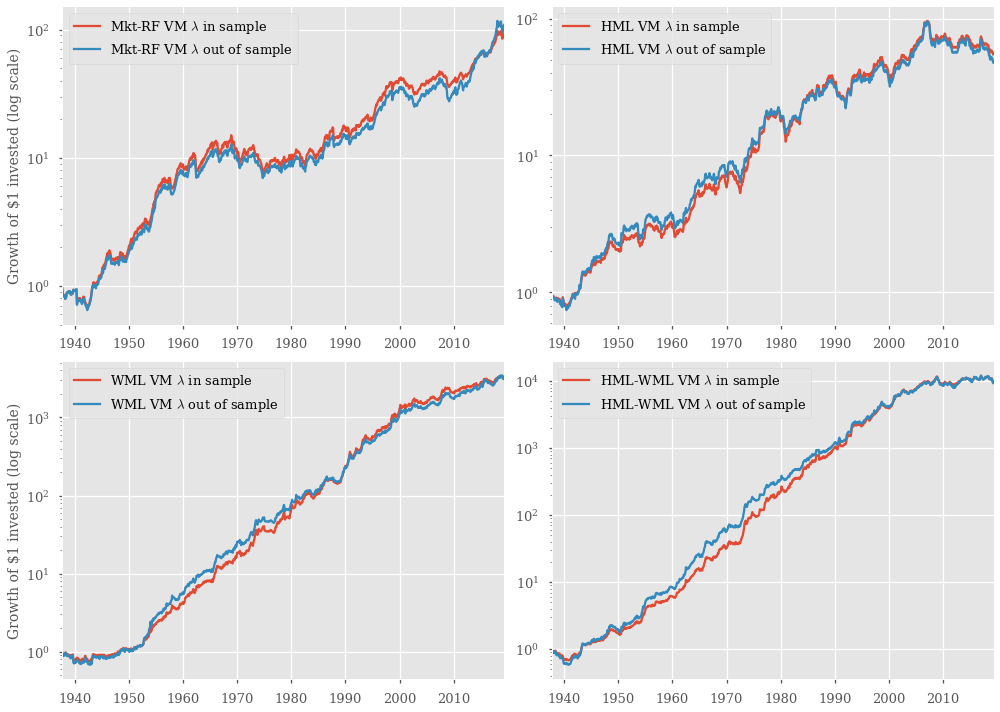

In [65]:
# vol managed portfolio in sample
df_weights_ul_is, df_scaled_ul_is = scaled_portfolio(returns=RETURNS[WINDOW:], 
                                                     risk=VOL[WINDOW:],target_level_vol=TARGET_VOL)


# write to csv in sample
write_to_csv(df_vm=df_scaled_ul_is,df_orig=RETURNS[WINDOW:],
             name="is_1937-2019",directory=PATH_DATA_2)

# Vol managed portfolio out of sample
tv_ul_target = target_dataframe_managed(df_returns=RETURNS,
                 df_risk=VOL,
                 span=WINDOW,
                 steps=STEPS,
                 target=TARGET_VOL)

# portfolio weights and managed returns
df_weight_ul_os = tv_ul_target.divide(VOL[WINDOW:])
df_scaled_ul_os = df_weight_ul_os.multiply(RETURNS[WINDOW:])

# write to csv out of sample
write_to_csv(df_vm=df_scaled_ul_os,df_orig=RETURNS[WINDOW:],
             name="os_1937-2019",directory=PATH_DATA_2)

# plot performance
plot_compare_return(df1=df_scaled_ul_is, 
                    df2=df_scaled_ul_os,
                    labels=["VM $\lambda$ in sample","VM $\lambda$ out of sample"])



# make summary table
in_sample = compare_perf_num(df1=df_scaled_ul_is,
                 df2=RETURNS[WINDOW:],
                 stat_CI=TEST_STAT,
                 sub_columns = ["UM","IS"],
                 names=["Portfolio", r"Strategy"])

oos= compare_perf_num(df1=df_scaled_ul_os,
                 df2=RETURNS[WINDOW:],
                 stat_CI=TEST_STAT,
                 sub_columns = ["UM","OOS"],
                 names=["Portfolio", r"Strategy"])


IS_OOS_list = []
for i in ["Mkt-RF","HML","WML","HML-WML"]:
    IS_OOS_list.append(in_sample.loc[:,i]["IS"])
    IS_OOS_list.append(oos.loc[:,i]["OOS"])

columns = pd.MultiIndex.from_product([["Mkt-RF","HML","WML","HML-WML"],
                                        ["IS","OOS"]],
                                       names=["Portfolio", "$\lambda$ estimation"])
IS_OOS = pd.DataFrame(IS_OOS_list).T
compare_perf_IS_OOS = pd.DataFrame(IS_OOS.values, columns=columns, index = IS_OOS.index)
compare_perf_IS_OOS

#print(compare_perf_IS_OOS.loc[METRICS_THESIS,:].to_latex())

#### $\lambda$ estimation

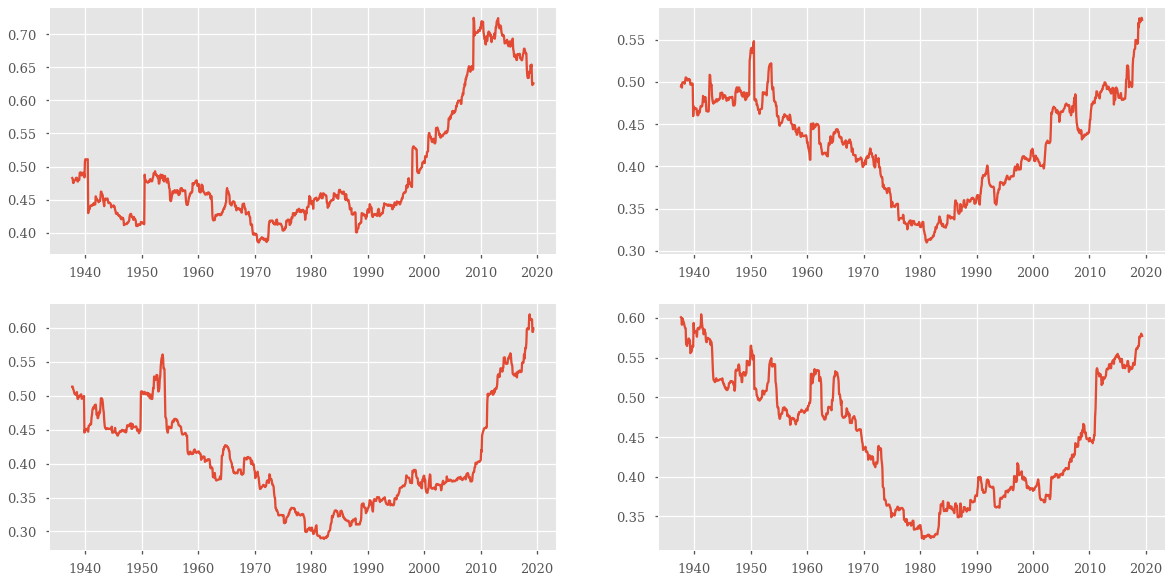

In [66]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
ax = ax.ravel()
for i,c in enumerate(tv_ul_target.columns):
    ax[i].plot(tv_ul_target[c])

In [67]:
oos

Portfolio          Mkt-RF             HML             WML          HML-WML  \
Strategy               UM     OOS      UM     OOS      UM      OOS      UM   
N                 981.000 981.000 981.000 981.000 981.000  981.000 981.000   
Min               -23.861 -24.285 -11.322 -11.367 -29.816  -18.988 -11.870   
25 %               -1.935  -1.576  -1.169  -1.633  -1.048   -1.163  -0.524   
50 %                1.015   0.857   0.196   0.294   0.647    0.720   0.380   
75 %                3.485   2.869   1.696   2.341   2.647    2.875   1.475   
Max                23.959  12.361  19.457  22.235  22.590   16.420  15.294   
Mean                0.645   0.541   0.357   0.457   0.571    0.886   0.430   
SD                  4.506   3.513   2.772   3.492   4.033    3.529   2.106   
Skew               -0.540  -0.759   0.673   0.552  -0.869   -0.078  -0.047   
Kurtosis            3.230   3.075   4.366   2.071   9.100    2.013   5.643   
Terminal Wealth   200.367 108.307  22.677  48.559 118.010 3124.135  54.390   
Mean (yr)           7.737   6.496   4.279   5.479   6.852   10.627   5.164   
SD (yr)            15.609  12.171   9.603  12.097  13.970   12.226   7.295   
SR (yr)             0.496   0.534   0.446   0.453   0.490    0.869   0.708   
SR                  0.143   0.154   0.129   0.131   0.142    0.251   0.204   
Kappa Ratio         0.139   0.148   0.150   0.162   0.121    0.284   0.207   
MDD (%)            55.528  45.454  39.746  49.832  56.562   30.990  32.267   
Calmar Ratio (yr)   0.139   0.143   0.108   0.110   0.121    0.343   0.160   
Max TUW (Year)     14.333  17.250  12.333  12.333  16.000   10.750  10.500   
Underwater (%)     76.656  79.409  80.020  81.346  81.651   73.496  72.783   
% MDD >20 %        25.586  25.484   9.582  22.732  32.620    4.179  14.475   
Diff SR             0.011   0.011   0.002   0.002   0.109    0.109   0.076   
Lower CI SR        -0.018  -0.018  -0.029  -0.029   0.070    0.070   0.043   
Upper CI SR         0.040   0.040   0.034   0.034   0.149    0.149   0.109   

Portfolio                   
Strategy               OOS  
N                  981.000  
Min                -10.410  
25 %                -1.165  
50 %                 0.843  
75 %                 2.993  
Max                 16.524  
Mean                 0.999  
SD                   3.564  
Skew                 0.347  
Kurtosis             1.174  
Terminal Wealth   9348.103  
Mean (yr)           11.986  
SD (yr)             12.345  
SR (yr)              0.971  
SR                   0.280  
Kappa Ratio          0.371  
MDD (%)             40.003  
Calmar Ratio (yr)    0.300  
Max TUW (Year)       6.833  
Underwater (%)      70.336  
% MDD >20 %          8.359  
Diff SR              0.076  
Lower CI SR          0.043  
Upper CI SR          0.109

In [68]:
in_sample

Portfolio          Mkt-RF             HML             WML          HML-WML  \
Strategy               UM      IS      UM      IS      UM       IS      UM   
N                 981.000 981.000 981.000 981.000 981.000  981.000 981.000   
Min               -23.861 -22.431 -11.322 -10.524 -29.816  -14.752 -11.870   
25 %               -1.935  -1.560  -1.169  -1.589  -1.048   -1.058  -0.524   
50 %                1.015   0.827   0.196   0.309   0.647    0.668   0.380   
75 %                3.485   2.726   1.696   2.331   2.647    2.822   1.475   
Max                23.959  11.662  19.457  16.898  22.590   15.462  15.294   
Mean                0.645   0.524   0.357   0.469   0.571    0.886   0.430   
SD                  4.506   3.464   2.772   3.464   4.033    3.464   2.106   
Skew               -0.540  -0.714   0.673   0.405  -0.869   -0.024  -0.047   
Kurtosis            3.230   2.713   4.366   1.199   9.100    1.716   5.643   
Terminal Wealth   200.367  93.349  22.677  55.377 118.010 3205.134  54.390   
Mean (yr)           7.737   6.292   4.279   5.631   6.852   10.630   5.164   
SD (yr)            15.609  12.000   9.603  12.000  13.970   12.000   7.295   
SR (yr)             0.496   0.524   0.446   0.469   0.490    0.886   0.708   
SR                  0.143   0.151   0.129   0.136   0.142    0.256   0.204   
Kappa Ratio         0.139   0.147   0.150   0.166   0.121    0.294   0.207   
MDD (%)            55.528  49.911  39.746  43.641  56.562   24.518  32.267   
Calmar Ratio (yr)   0.139   0.126   0.108   0.129   0.121    0.434   0.160   
Max TUW (Year)     14.333  17.500  12.333  12.333  16.000   10.250  10.500   
Underwater (%)     76.656  79.409  80.020  81.346  81.651   73.496  72.783   
% MDD >20 %        25.586  25.076   9.582  22.834  32.620    2.650  14.475   
Diff SR             0.008   0.008   0.007   0.007   0.114    0.114   0.085   
Lower CI SR        -0.023  -0.023  -0.024  -0.024   0.075    0.075   0.052   
Upper CI SR         0.039   0.039   0.038   0.038   0.153    0.153   0.117   

Portfolio                   
Strategy                IS  
N                  981.000  
Min                -12.140  
25 %                -1.075  
50 %                 0.816  
75 %                 2.990  
Max                 15.604  
Mean                 1.000  
SD                   3.464  
Skew                 0.331  
Kurtosis             1.397  
Terminal Wealth   9814.495  
Mean (yr)           12.005  
SD (yr)             12.000  
SR (yr)              1.000  
SR                   0.289  
Kappa Ratio          0.376  
MDD (%)             30.858  
Calmar Ratio (yr)    0.389  
Max TUW (Year)       8.083  
Underwater (%)      70.438  
% MDD >20 %          5.606  
Diff SR              0.085  
Lower CI SR          0.052  
Upper CI SR          0.117

### Closer look at momentum

#### Data crash 1929 and  Financial Crisis (2007)

In [69]:

MOMENTUM = '6_Portfolios_ME_Prior_12_2_daily'


# load the data for the momentum factor
dic_WML = web.DataReader(MOMENTUM, 'famafrench', start=START_YEAR)
print(dic_WML['DESCR'])

df_WML = dic_WML[0]
df_WML.index = df_WML.index.astype('datetime64[ns]')


# long short momentum portfolio
longs, shorts = ['SMALL HiPRIOR',
                 'BIG HiPRIOR'], ['SMALL LoPRIOR', 'BIG LoPRIOR']


df_WML_Winners_Losers = pd.DataFrame({"Winners":df_WML.loc[:, longs].mean(axis=1),
                                      "Losers":df_WML.loc[:, shorts].mean(axis=1)})

df_WML_Winners_Losers = ((1+df_WML_Winners_Losers/100).resample('1M').prod()-1)*100
#(((1+df_daily/100).resample("1M").prod()-1)*100)[window+1:] 

6 Portfolios ME Prior 12 2 daily
--------------------------------

This file was created by CMPT_ME_PRIOR_RETS_DAILY using the 201904 CRSP database. It contains value- weighted returns for the intersections of 2 ME portfolios and 3 prior return portfolios. The portfolios are constructed daily. ME is market cap at the end of the previous day. PRIOR_RET is from - 250 to - 21. Missing data are indicated by -99.99 or -999. Copyright 2019 Kenneth R. French

  0 : Average Value Weighted Returns -- Daily (24323 rows x 6 cols)
  1 : Average Equal Weighted Returns -- Daily (24323 rows x 6 cols)


In [70]:

# experienced vol that month (looking 1 month ahead thus)
RV = np.sqrt(df_daily**2).resample("1M").sum()
# no shift 1 to use the vol of that month (sort of check for max potential)
RV_max  = ((RV.rolling(window=1).sum()/21))



#===========================================
# 1929
#===========================================
ys,ms,ds = 1927,12,31
ye,me,de = 1935,12,31

# subset returns and risk (predicted vol)
returns_crash_29 = RETURNS.loc[datetime.date(year=ys,month=ms,day=ds):
                                     datetime.date(year=ye,month=me,day=de)]

# predicted risk
risk_crash_29 = VOL.loc[datetime.date(year=ys,month=ms,day=ds):
                                  datetime.date(year=ye,month=me,day=de)]

# get scaled portfolio
df_weights_crash_29, df_scaled_crash_29 = scaled_portfolio(returns=returns_crash_29, 
                                                         risk=risk_crash_29, max_weight=10)

#experienced vol that month
risk_crash_29_t1 = RV_max.loc[datetime.date(year=ys,month=ms,day=ds):
                                  datetime.date(year=ye,month=me,day=de)]

# long and short leg momentum
# get the minimum (crash) date 
minimum_crash_29 = ((1+returns_crash_29["Mkt-RF"]/100).cumprod()).idxmin()
df_WML_29 = df_WML_Winners_Losers.loc[datetime.date(year=ys,month=ms,day=ds):
                                  datetime.date(year=ye,month=me,day=de)]

discount_29 = ((1+df_WML_29/100).cumprod()).loc[minimum_crash_29]
df_WML_29_disounted = ((1+df_WML_29/100).cumprod())/discount_29

#===========================================
# Finacial Crisis (2007)
#===========================================

ys,ms,ds = 2006,1,1
ye,me,de = 2012,12,31

# subset returns and risk (predicted vol)
returns_crash_07 = RETURNS.loc[datetime.date(year=ys,month=ms,day=ds):
                                     datetime.date(year=ye,month=me,day=de)]
# predicted risk
risk_crash_07 = VOL.loc[datetime.date(year=ys,month=ms,day=ds):
                                  datetime.date(year=ye,month=me,day=de)]

# get scaled portfolio
df_weights_crash_07, df_scaled_crash_07 = scaled_portfolio(returns=returns_crash_07, 
                                                         risk=risk_crash_07, max_weight=10)


#experienced vol that month
risk_crash_07_t1 = RV_max.loc[datetime.date(year=ys,month=ms,day=ds):
                                  datetime.date(year=ye,month=me,day=de)]


# long and short leg momentum
#get the minimum (crash) date 
minimum_crash_07 = ((1+returns_crash_07["Mkt-RF"]/100).cumprod()).idxmin()
df_WML_07 = df_WML_Winners_Losers.loc[datetime.date(year=ys,month=ms,day=ds):
                                  datetime.date(year=ye,month=me,day=de)]

discount_07 = ((1+df_WML_07/100).cumprod()).loc[minimum_crash_07]
df_WML_07_disounted = ((1+df_WML_07/100).cumprod())/discount_07

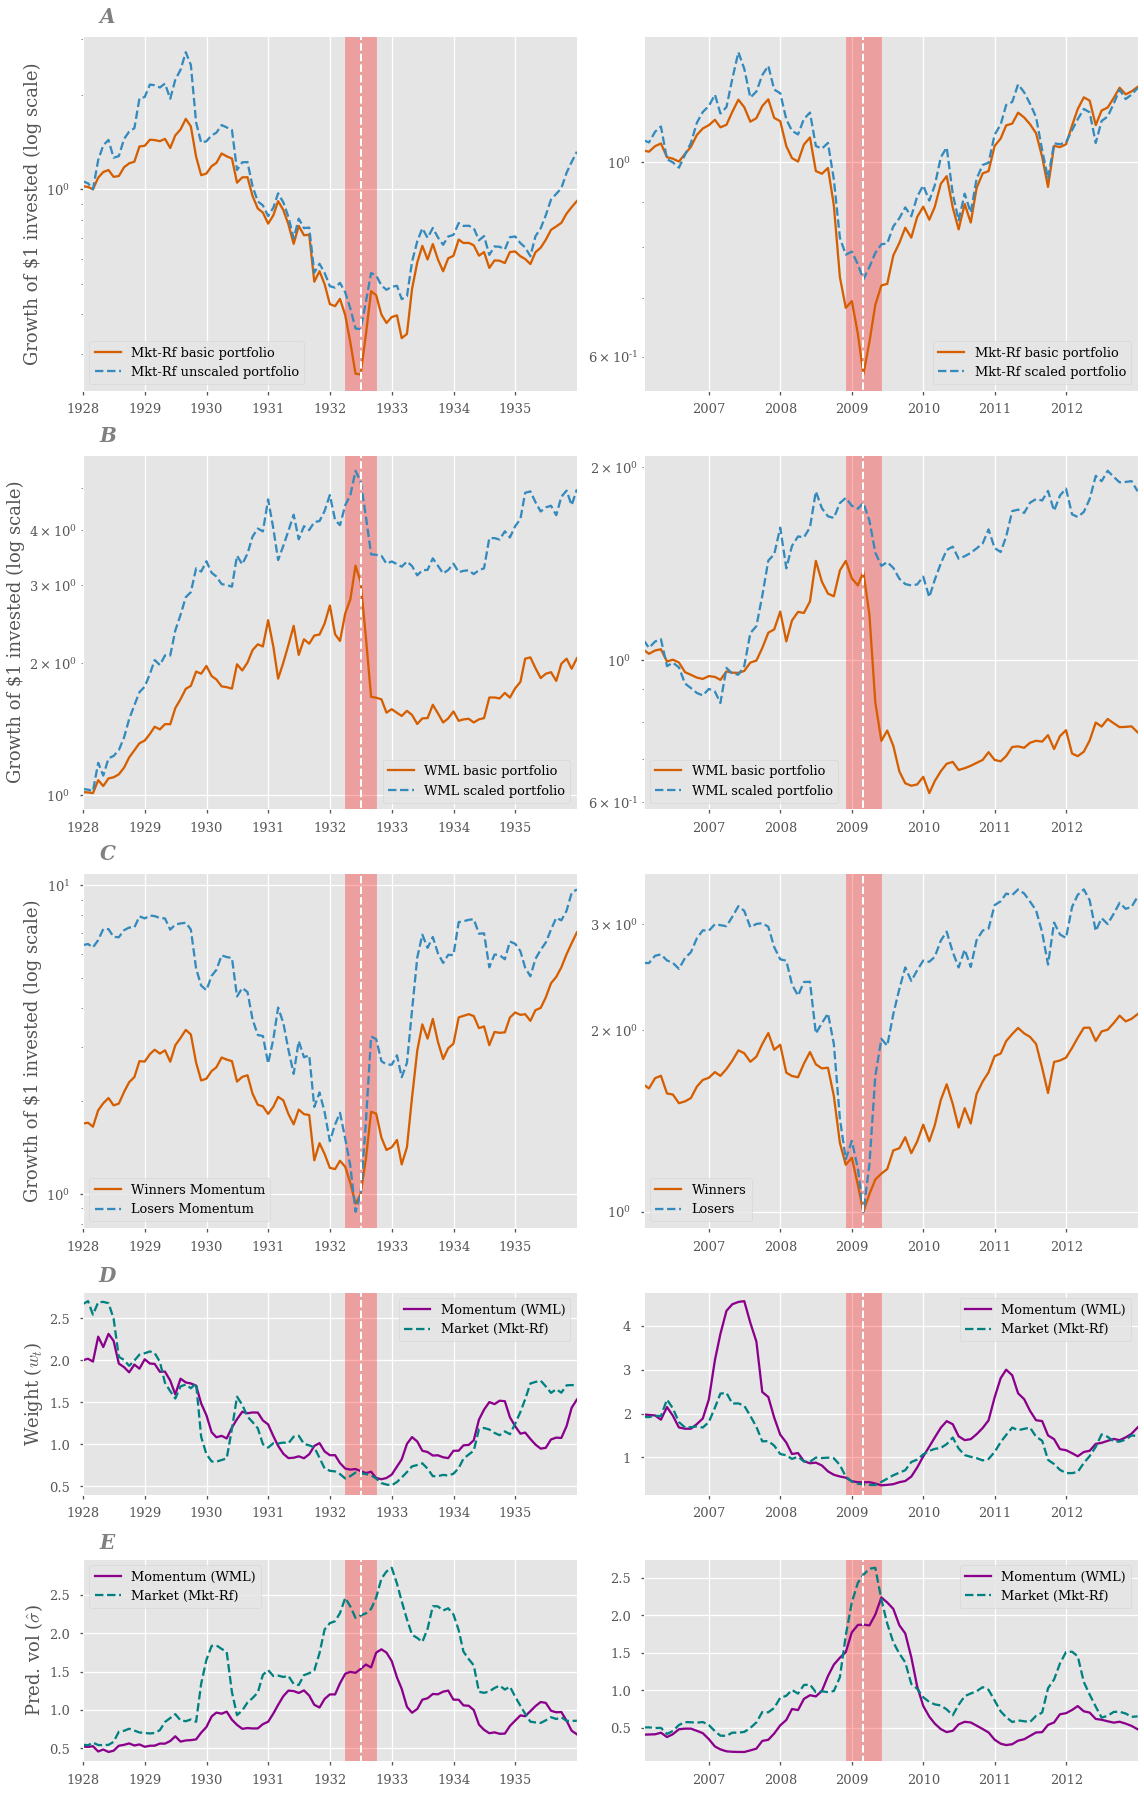

In [71]:
# colors
C0 = "#D55E00"
C1 = "C1"
C2="darkmagenta" 
C3="teal"
span = 3
C4 = "red"
C5 = "white"


height_ratio = [1.75, 1.75,1.75, 1, 1]
fig, ax = plt.subplots(5,2,figsize=(16,25),gridspec_kw={'height_ratios': height_ratio})


# cum return
# 1929
ax[0,0].plot((1+returns_crash_29["Mkt-RF"]/100).cumprod(),label="Mkt-Rf basic portfolio",c=C0);
ax[0,0].plot((1+df_scaled_crash_29["Mkt-RF"]/100).cumprod(),
             label="Mkt-Rf unscaled portfolio",linestyle="--",c=C1);
ax[1,0].plot((1+returns_crash_29["WML"]/100).cumprod(),label="WML basic portfolio",c=C0);
ax[1,0].plot((1+df_scaled_crash_29["WML"]/100).cumprod(),label="WML scaled portfolio",linestyle="--",c=C1);

# cum return
# 1929 long and short leg momentum
ax[2,0].plot(df_WML_29_disounted["Winners"],label="Winners Momentum",c=C0);
ax[2,0].plot(df_WML_29_disounted["Losers"],label="Losers Momentum",linestyle="--",c=C1);

# cum return
# 2007
ax[0,1].plot((1+returns_crash_07["Mkt-RF"]/100).cumprod(),label="Mkt-Rf basic portfolio",c=C0);
ax[0,1].plot((1+df_scaled_crash_07["Mkt-RF"]/100).cumprod(),label="Mkt-Rf scaled portfolio",linestyle="--",c=C1);
ax[1,1].plot((1+returns_crash_07["WML"]/100).cumprod(),label="WML basic portfolio",c=C0);
ax[1,1].plot((1+df_scaled_crash_07["WML"]/100).cumprod(),label="WML scaled portfolio",linestyle="--",c=C1);

# cum return
# 2007 long and short leg momentum
ax[2,1].plot(df_WML_07_disounted["Winners"], label="Winners",c=C0);
ax[2,1].plot(df_WML_07_disounted["Losers"], label="Losers",linestyle="--",c=C1);


# weights
# 1929
ax[3,0].plot(df_weights_crash_29["WML"],label="Momentum (WML)",c=C2);
ax[3,0].plot(df_weights_crash_29["Mkt-RF"],label="Market (Mkt-Rf)",linestyle="--",c=C3);
# 2007
ax[3,1].plot(df_weights_crash_07["WML"],label="Momentum (WML)",c=C2);
ax[3,1].plot(df_weights_crash_07["Mkt-RF"],label="Market (Mkt-Rf)",linestyle="--",c=C3);

# predicted volatility
ax[4,0].plot(risk_crash_29["WML"],label="Momentum (WML)",c=C2);
ax[4,0].plot(risk_crash_29["Mkt-RF"],label="Market (Mkt-Rf)",linestyle="--",c=C3);
# 2007
ax[4,1].plot(risk_crash_07["WML"],label="Momentum (WML)",c=C2);
ax[4,1].plot(risk_crash_07["Mkt-RF"],label="Market (Mkt-Rf)",linestyle="--",c=C3);


# expierenced volatility
#ax[5,0].plot(risk_crash_29_t1["WML"],label="Momentum (WML)",c=C2);
#ax[5,0].plot(risk_crash_29_t1["Mkt-RF"],label="Market (Mkt-Rf)",linestyle="--",c=C3);
# 2007
#ax[5,1].plot(risk_crash_07_t1["WML"],label="Momentum (WML)",c=C2);
#ax[5,1].plot(risk_crash_07_t1["Mkt-RF"],label="Market (Mkt-Rf)",linestyle="--",c=C3);


ax[0,0].set_yscale('log')
ax[1,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,1].set_yscale('log')
ax[2,0].set_yscale('log')
ax[2,1].set_yscale('log')

for i in range(5):
    for j in range(2):
        ax[i,j].legend(loc="best")
        if j == 0:
            ax[i,j].axvspan(minimum_crash_29-span, minimum_crash_29+span, color=C4, alpha=0.3)
            ax[i,j].axvline(x=minimum_crash_29, ymin=-2, ymax=1,c=C5,linestyle="--",lw=2);
            ax[i,j].set_xlim([returns_crash_29.index[0], returns_crash_29.index[-1]])
        else:
            ax[i,j].axvspan(minimum_crash_07-span, minimum_crash_07+span, color=C4, alpha=0.3)
            ax[i,j].axvline(x=minimum_crash_07, ymin=-2, ymax=1,c=C5,linestyle="--",lw=2);
            ax[i,j].set_xlim([returns_crash_07.index[0], returns_crash_07.index[-1]])
            
ax[0,0].set_ylabel("Growth of $1 invested (log scale)",fontsize=18)
ax[1,0].set_ylabel("Growth of $1 invested (log scale)",fontsize=18)
ax[2,0].set_ylabel("Growth of $1 invested (log scale)",fontsize=18)
ax[3,0].set_ylabel(r"Weight ($w_t$)",fontsize=18)
ax[4,0].set_ylabel(r"Pred. vol ($\hat{\sigma}$)",fontsize=18)
#ax[5,0].set_ylabel(r"Realized vol",fontsize=18)

#ax[0,0].set_title("Crash of 1929",style="italic",fontweight="bold",x=.55,y=1.02,fontsize=20)
#ax[0,1].set_title("Financial crisis",style="italic",fontweight="bold",x=.45,y=1.02,fontsize=20)


for i,j in enumerate(["A","B","C","D","E"]):
    ax[i,0].set_title(f"{j}",style="italic",fontweight="bold",x=.05,y=1.02,fontsize=20,c="grey")

plt.tight_layout()
plt.savefig('Momentum_zoom.pdf', format='pdf')

In [72]:
df_WML_29["Mkt-Rf"] = returns_crash_29["Mkt-RF"]
(1+df_WML_29.loc[minimum_crash_29:minimum_crash_29+5]/100).cumprod()

Winners  Losers  Mkt-Rf
Date                               
1932-06-30    1.074   1.141   0.994
1932-07-31    1.393   1.948   1.331
1932-08-31    1.986   3.696   1.830
1932-09-30    1.958   3.626   1.777
1932-10-31    1.637   3.076   1.542
1932-11-30    1.494   2.999   1.450

In [73]:
df_WML_07["Mkt-Rf"] = returns_crash_07["Mkt-RF"]
(1+df_WML_07.loc[minimum_crash_07:minimum_crash_07+5]/100).cumprod()

Winners  Losers  Mkt-Rf
Date                               
2009-02-28    0.903   0.848   0.899
2009-03-31    0.967   1.017   0.979
2009-04-30    1.022   1.425   1.079
2009-05-31    1.045   1.642   1.136
2009-06-30    1.063   1.599   1.140
2009-07-31    1.142   1.805   1.229